# 3. Cluster Analysis

This notebook performs a cluster analysis on the data set df_trips based on various parameters and also includes clustering based on weather and spatial features.

**Task** <br>
Getting a deep understanding of how customers use your mobility service is crucial.
As an example, for marketing purposes, or managerial decisions. One widely adopted approach to
understand customers’ behavior is to find prevalent usage/trip clusters. Tasks: Based on the taxi trip
patterns, can you identify clusters of trip types and/or customer types? How would you label these
clusters? Methods: Identify clusters with soft-clustering and visualize your results. Compare your
results to a hard-clustering method of your choice. You can use additional features like “distance to city
center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI
data.
Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e.,
using Spatial Kernel Density Estimation)?

**Structure**
1. trips
2. weather-based
3. spatial


### Imports

In [1]:
import vaex
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium
import seaborn as sns

import geopandas as gpd

import h3
from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Defines

In [3]:
# hex resolution
HEX_RES = 9
# test mode
TEST_MODE = False

## Helper Methods
Collection of helper methods for various repetitive tasks. The collection is structured by the category of the method as followed:
1. Data Cleaning
2. Clustering Helper
3. Data Visualization and Evaluation


#### 1. Data cleaning and preparation
Collection of methods used for data cleaning on all datasets. The main functionality is to remove Nan values and to replace outliers in the dataset.

In [4]:
def outlier_thresholds(dataframe, feature):
    """
    Method to find outlier in a feature
    Returns the lower and upper limit
    """
    lower_quantile = dataframe[feature].quantile(0.10)
    upper_quantile = dataframe[feature].quantile(0.90)
    interquantile_range = upper_quantile - lower_quantile
    up_limit  = upper_quantile + 1.5 * interquantile_range
    low_limit = lower_quantile - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, feature):
    """
    Method to replace outlier in a feature.
    It replaces outliers by the lower or upper limit.    
    """
    low_limit, up_limit = outlier_thresholds(dataframe, feature)
    dataframe.loc[(dataframe[feature] < low_limit), feature] = low_limit
    dataframe.loc[(dataframe[feature] > up_limit), feature] = up_limit

def remove_all_outliers(dataframe):
    """
    Method to iterate over all columns of a dataframe to replace all outliers
    """
    for col in dataframe.select_dtypes([np.number]).columns:
        dataframe[col].fillna(0, inplace=True)
        replace_with_thresholds(dataframe, col)

In [5]:
def scale_df(dataframe):
    scaler = StandardScaler()
    scaler.fit(dataframe)
    dataframe_scaled = scaler.transform(dataframe)

    scaled_df = pd.DataFrame(dataframe_scaled, columns = dataframe.columns, index = dataframe.index)

    return scaled_df

#### 2. Clustering Helper
Collection of methods to encapsulate repetitive tasks during the clustering (e.g. Scaling, GridSearch, fitting, prediction)

In [6]:
def gridSearch(scaled_dataframe, n_clusters_max = 6):
    """
    Method that performs a grid search with the given model and plots the results.
    """
    clusters = []
    losses = []

    for k in range(n_clusters_max):
        model = KMeans(n_clusters = k + 1, n_init=10, init="k-means++", random_state=42)
        model.fit(scaled_dataframe)
        clusters.append(k+1)
        losses.append(model.inertia_)
        
    # plot grid search result
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.show()

In [7]:
def fit_and_predict(model, scaled_dataframe, dataframe):
    model.fit(scaled_dataframe)
    dataframe[f'cluster_{model.__class__.__name__}'] =  model.predict(scaled_dataframe)

#### 3. Data Visualization and Evaluation
Collection of methods to visualize the dataframe and the clustering results

In [8]:
def plt_corr(dataframe):
    """
    Method to plot a correlation matrix for the dataset.
    """
    base_df_corr = dataframe.corr()
    mask = np.triu(np.ones_like(base_df_corr, dtype=bool))
    f = plt.figure()
    f.set_figwidth(20)
    f.set_figwidth(20)
    sns.heatmap(base_df_corr, annot = True, vmax= 1, vmin= -1, center=0, cmap='vlag', mask = mask)
    plt.show()

In [9]:
def feature_distribution(dataframe, cluster_column):
    """
    Method that returns a evaluation of each cluster including mean and std of each feature, the number of elements per cluster and the most frequent value per feature
    """
    # seperate feature columns
    feature_cols = list(filter(lambda x: not x.startswith('cluster'), dataframe.columns))
    # aggregate by cluster col
    feature_distribution_df = dataframe.groupby(cluster_column).agg(['mean', 'std'])[feature_cols]
    # add sizes
    feature_distribution_df["cluster_size"] = dataframe.groupby(cluster_column).size()
    # add value with the highest share
    value_frequencies =  dataframe.groupby(cluster_column).agg(lambda x:x.value_counts().index[0])
    for col in feature_cols:
        feature_distribution_df[f'first_{col}'] = value_frequencies[col]
    
    return feature_distribution_df

In [10]:
def plt_violins(dataframe):
        """
        Method to plot violin charts of the clustering results including a bar plot of the cluster sizes.
        """
 
        cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
        feature_cols = list(filter(lambda x: not x.startswith('cluster'), dataframe.columns))

        fig, axes = plt.subplots(nrows = len(feature_cols) + 1, ncols = len(cluster_cols), figsize = (20,15))

        # iterate over all input features to plot the value distribution across the clusters  
        for cluster_id, cluster_col in enumerate(cluster_cols):
                for feature_id, feat in enumerate(feature_cols):
                        sns.violinplot(ax = axes[feature_id, cluster_id], x=dataframe[cluster_col], y=dataframe[feat], data=dataframe)
                        axes[feature_id, cluster_id].set_title(f'{cluster_col} - {feat}')
                # add cluster size to the plot
                cluster_size = dataframe.groupby(cluster_col).size()
                axes[len(feature_cols), cluster_id].bar(cluster_size.index, cluster_size)
                axes[len(feature_cols), cluster_id].set_title(f'{cluster_col} - Cluster Sizes')

        fig.tight_layout()
        plt.show()

In [11]:
def plt_cluster_size(dataframe):
        """
        Method to plot a bar plot of the cluster sizes.
        """
 
        cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
        fig, axes = plt.subplots(nrows = 1, ncols = len(cluster_cols), figsize = (20,5))

        # iterate over all input features to plot the value distribution across the clusters  
        for cluster_id, cluster_col in enumerate(cluster_cols):
                # add cluster size to the plot
                cluster_size = dataframe.groupby(cluster_col).size()
                axes[cluster_id].bar(cluster_size.index, cluster_size)
                axes[cluster_id].set_title(f'{cluster_col} - Cluster Sizes')

        fig.tight_layout()
        plt.show()

In [12]:
def hex_to_map(dataframe):
    """
        Method to plot a map per cluster.
    """
    # create new dataframe with based on all cluster columns
    cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))    
    map_df = dataframe[cluster_cols]

    #convert hex to polygon
    map_df['hex'] = dataframe.index
    map_df = map_df[map_df.hex != 'None']
    map_df['geometry'] = map_df['hex'].apply(lambda id: Polygon(h3.cell_to_boundary(id, geo_json=True)))  
    

    # create geopandas dataframe
    map_gdf = gpd.GeoDataFrame(map_df[['geometry'] + cluster_cols ], crs='EPSG:4326')
    
    map = None

    for col in cluster_cols:
        map = map_gdf.explore(m = map, column = col, name = col)
    
    folium.LayerControl().add_to(map)
    
    return map    

In [13]:
 def plt_temporal_patterns(dataframe, no_cluster):
    """
        Method to plot temporal patterns.
    """
    cluster_cols = list(filter(lambda x: x.startswith('cluster'), dataframe.columns))
   
    fig, ax = plt.subplots(nrows = len(cluster_cols), ncols = no_cluster, figsize=(20,16))
    
    for cluster in range(0, no_cluster):
        for idx, cluster_col in enumerate(cluster_cols):
            dataframe[dataframe[cluster_col] == cluster].drop(columns = cluster_cols).T.plot(ax=ax[idx, cluster], color='#8f3371', alpha=0.05)
            dataframe[dataframe[cluster_col] == cluster].drop(columns = cluster_cols).mean(numeric_only=True).T.plot(ax=ax[0, cluster], color = '#8f3371', alpha=1)
            ax[idx, cluster].get_legend().remove()
            ax[idx, cluster].set_title(f'{cluster_col} Cluster: {cluster}')
            ax[idx, cluster].set_xlim([0,23])
            ax[idx, cluster].set_xticks(np.arange(0,23))
    
    for idx, cluster_col in enumerate(cluster_cols):
        ax[idx, 0].set_ylabel('Number of Trips')

    plt.show()

## Data loading and preparation

1. Loading the data from different sources:
    - trip data
    - weather data
    - poi data
2. Selecting the relevant features and add additional features

### Trip data

In [14]:
# Load trip data from vaex df data/trips/trips_prepared.hdf
df_trips = vaex.open('data/trips/trips_prepared.hdf')

# for testing with reduced lines
if TEST_MODE:
    df_trips = df_trips.sample(n=100000, random_state=42)

In [15]:
df_trips.info()

#### Feature selection and conversion to pandas

In [16]:
# feature selection

features = ['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin', 'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin', 'start_1_hour_cos', 'Trip Seconds', 'Trip Total', f'pickup_hex_{HEX_RES}', f'dropoff_hex_{HEX_RES}', 'Payment Type_Cash', 'Payment Type_Credit Card']

# convert vaex to pandas dataframe
df_trips = df_trips[features].to_pandas_df()

#### Data cleaning

In [17]:
remove_all_outliers(df_trips)

In [18]:
df_trips = df_trips[df_trips[f'pickup_hex_{HEX_RES}']  != 'None']
df_trips = df_trips[df_trips[f'dropoff_hex_{HEX_RES}'] != 'None']

### Calculation of additional features
Calculation of hexagon based features as the distance to the center (location with the highest amount of ride starts) for Pickup and Dropoff and the direction of the ride (is the ride going to or away from the center). The measure is the number of hexagons.

In [19]:
# defining the city center by selecting the hexagon with the most pickups as center
center_hex = df_trips[f'pickup_hex_{HEX_RES}'].value_counts().idxmax()

print(f'Center hexagon: {center_hex}')

# calculate distances. Invalid hexagons result in 0.
df_trips['dist_center_pickup']  = df_trips.apply(lambda row: h3.grid_distance(row[f'pickup_hex_{HEX_RES}'] if h3.is_valid_cell(row[f'pickup_hex_{HEX_RES}']) else center_hex, center_hex), axis=1)
df_trips['dist_center_dropoff'] = df_trips.apply(lambda row: h3.grid_distance(row[f'dropoff_hex_{HEX_RES}'] if h3.is_valid_cell(row[f'dropoff_hex_{HEX_RES}']) else center_hex, center_hex), axis=1)

# direction -> negative values represent trips going away from the center whereas positive values represent trips to the center.
df_trips['direction']           = df_trips['dist_center_dropoff'] - df_trips['dist_center_pickup']                                                                    

Center hexagon: 892664c1a8bffff


Calculation of additional time-based features

In [20]:
# is_weekend: 1 for week end, 0 for weekdays
df_trips['is_weekend'] = np.where(df_trips['start_weekday'] >= 5, 1, 0)

In [21]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

### Weather data

In [22]:
df_weather = pd.read_pickle('data/weather.pickle')

In [23]:
df_weather.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'Precip.', 'cloud', 'rain',
       'Fair', 'Fog', 'Snow', 'T-Storm', 'Thunder'],
      dtype='object')

In [24]:
#weather_attributes = ['Temperature', 'Humidity', 'Wind Speed', 'Precip.', 'cloud', 'rain', 'Fair', 'Fog', 'Snow', 'T-Storm', 'Thunder']
weather_attributes = ['Temperature', 'Precip.', 'cloud']

df_weather = df_weather[weather_attributes]

In [25]:
df_weather

Temperature  Precip.  cloud
datetime                                        
2014-01-01 00:00:00        -10.0      0.0    3.0
2014-01-01 01:00:00         -8.9      0.0    3.0
2014-01-01 02:00:00         -8.3      0.0    3.0
2014-01-01 03:00:00         -7.8      0.0    3.0
2014-01-01 04:00:00         -7.2      0.0    3.0
...                          ...      ...    ...
2014-12-31 19:00:00         -7.2      0.0    0.0
2014-12-31 20:00:00         -7.2      0.0    0.0
2014-12-31 21:00:00         -6.7      0.0    0.0
2014-12-31 22:00:00         -6.7      0.0    0.0
2014-12-31 23:00:00         -6.7      0.0    0.0

[8760 rows x 3 columns]

### POI data

In [26]:
df_poi = pd.read_pickle('data/poi/poi_prepared.pickle')

In [27]:
df_poi

amenity  \
osmid                         
258490031           parking   
269449042  parking_entrance   
269450074  parking_entrance   
269688947          post_box   
270863340  parking_entrance   
...                     ...   
13621412                NaN   
13621413                NaN   
13621414                NaN   
15910906                NaN   
15910907                NaN   

                                                    geometry name  \
osmid                                                               
258490031                         POINT (-87.64385 41.95123)  NaN   
269449042                         POINT (-87.61506 41.85869)  NaN   
269450074                         POINT (-87.58421 41.79174)  NaN   
269688947                         POINT (-87.77220 42.00407)  NaN   
270863340                         POINT (-87.61564 41.86421)  NaN   
...                                                      ...  ...   
13621412   POLYGON ((-87.66859 41.91735, -87.66895 41.917...  NaN   
13621413   POLYGON ((-87.66793 41.91671, -87.66797 41.916...  NaN   
13621414   POLYGON ((-87.66801 41.91728, -87.66800 41.917...  NaN   
15910906   POLYGON ((-87.62624 41.87979, -87.62623 41.879...  NaN   
15910907   POLYGON ((-87.62610 41.87984, -87.62610 41.880...  NaN   

                   category   latitude  longitude public_transport wheelchair  \
osmid                                                                           
258490031           parking  41.951227 -87.643847              NaN        NaN   
269449042           parking  41.858689 -87.615058              NaN        NaN   
269450074           parking  41.791742 -87.584208              NaN        NaN   
269688947             other  42.004073 -87.772198              NaN        NaN   
270863340           parking  41.864208 -87.615638              NaN        NaN   
...                     ...        ...        ...              ...        ...   
13621412   public_transport  41.917203 -87.668448         platform        NaN   
13621413   public_transport  41.917215 -87.668182         platform        NaN   
13621414   public_transport  41.917277 -87.668066         platform        NaN   
15910906   public_transport  41.879543 -87.626201         platform         no   
15910907   public_transport  41.879567 -87.626064         platform         no   

                     hex_7            hex_8            hex_9  \
osmid                                                          
258490031  872664c14ffffff  882664c145fffff  892664c144fffff   
269449042  872664c1bffffff  882664c1b1fffff  892664c1b03ffff   
269450074  872664cc5ffffff  882664cc59fffff  892664cc583ffff   
269688947  872664d9effffff  882664d9e1fffff  892664d9e0fffff   
270863340  872664c1bffffff  882664c1bdfffff  892664c1bc7ffff   
...                    ...              ...              ...   
13621412   872664c12ffffff  882664cac9fffff  892664cac93ffff   
13621413   872664c12ffffff  882664cac9fffff  892664cac93ffff   
13621414   872664c12ffffff  882664cac9fffff  892664cac93ffff   
15910906   872664c1affffff  882664c1a9fffff  892664c1a87ffff   
15910907   872664c1affffff  882664c1a9fffff  892664c1a87ffff   

                                                       pol_7  \
osmid                                                          
258490031  POLYGON ((-87.63414405293 41.96445315471353, -...   
269449042  POLYGON ((-87.61820944356228 41.8710984903598,...   
269450074  POLYGON ((-87.5937067068291 41.798228672497444...   
269688947  POLYGON ((-87.7773181551225 42.01982017726515,...   
270863340  POLYGON ((-87.61820944356228 41.8710984903598,...   
...                                                      ...   
13621412   POLYGON ((-87.6723729663648 41.93963771855481,...   
13621413   POLYGON ((-87.6723729663648 41.93963771855481,...   
13621414   POLYGON ((-87.6723729663648 41.93963771855481,...   
15910906   POLYGON ((-87.63912440648137 41.88713767856642...   
15910907   POLYGON ((-87.63912440648137 41.88713767856642...   

In [28]:
df_poi_category = df_poi.groupby(by=[ 'category', f'hex_{HEX_RES}']).count()['geometry'].unstack(0).fillna(0)
df_poi_category

category         bicycle_parking  bicycle_rental  bicycle_repair_station  \
hex_9                                                                      
89266419027ffff              0.0             0.0                     0.0   
8926641902bffff              0.0             0.0                     0.0   
8926641902fffff              0.0             0.0                     0.0   
89266419037ffff              0.0             0.0                     0.0   
89266419073ffff              0.0             0.0                     0.0   
...                          ...             ...                     ...   
89275936dc7ffff              0.0             0.0                     0.0   
89275936dcbffff              0.0             0.0                     0.0   
89275936dcfffff              0.0             0.0                     0.0   
89275936dd3ffff              0.0             0.0                     0.0   
89275936ddbffff              0.0             0.0                     0.0   

category         car_rental  car_sharing  children  culture  education  \
hex_9                                                                    
89266419027ffff         0.0          0.0       0.0      0.0        0.0   
8926641902bffff         0.0          0.0       0.0      0.0        0.0   
8926641902fffff         0.0          0.0       0.0      0.0        0.0   
89266419037ffff         0.0          0.0       0.0      0.0        0.0   
89266419073ffff         0.0          0.0       0.0      0.0        0.0   
...                     ...          ...       ...      ...        ...   
89275936dc7ffff         0.0          0.0       0.0      0.0        0.0   
89275936dcbffff         0.0          0.0       0.0      0.0        0.0   
89275936dcfffff         0.0          0.0       0.0      0.0        0.0   
89275936dd3ffff         0.0          0.0       0.0      0.0        0.0   
89275936ddbffff         0.0          0.0       0.0      0.0        1.0   

category         finance  fuel  ...  health  nightlife  other  parking  \
hex_9                           ...                                      
89266419027ffff      0.0   0.0  ...     0.0        0.0    0.0      4.0   
8926641902bffff      0.0   0.0  ...     0.0        0.0    0.0      3.0   
8926641902fffff      0.0   0.0  ...     0.0        0.0    0.0      1.0   
89266419037ffff      0.0   0.0  ...     0.0        0.0    0.0      2.0   
89266419073ffff      0.0   0.0  ...     0.0        0.0    0.0      1.0   
...                  ...   ...  ...     ...        ...    ...      ...   
89275936dc7ffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   
89275936dcbffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   
89275936dcfffff      0.0   0.0  ...     0.0        0.0    1.0      0.0   
89275936dd3ffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   
89275936ddbffff      0.0   0.0  ...     0.0        0.0    0.0      0.0   

category         place_of_worship  police  public_transport  sports  taxi  \
hex_9                                                                       
89266419027ffff               0.0     0.0               0.0     0.0   0.0   
8926641902bffff               0.0     0.0               0.0     0.0   0.0   
8926641902fffff               0.0     0.0               0.0     0.0   0.0   
89266419037ffff               0.0     0.0               0.0     0.0   0.0   
89266419073ffff               0.0     0.0               0.0     0.0   0.0   
...                           ...     ...               ...     ...   ...   
89275936dc7ffff               0.0     0.0               1.0     0.0   0.0   
89275936dcbffff               0.0     0.0               2.0     0.0   0.0   
89275936dcfffff               0.0     0.0               1.0     0.0   0.0   
89275936dd3ffff               0.0     0.0               1.0     0.0   0.0   
89275936ddbffff               1.0     0.0               0.0     0.0   0.0   

category         water_transport  
hex_9                             
89266419027ff

# Trip-based clustering

## Trip clustering

Clustering based on trip information as direction and time.

In [29]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [30]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [31]:
# Clustering features
trips_clust_feat     = ['is_weekend',  'start_1_hour', 'Trip Seconds', 'dist_center_pickup', 'dist_center_dropoff', 'direction']
# Encoded features
trips_enc_clust_feat = ['is_weekend',  'start_1_hour_sin', 'start_1_hour_cos', 'Trip Seconds', 'dist_center_pickup', 'dist_center_dropoff', 'direction']

df_trips_clust = df_trips[trips_clust_feat]
df_trips_enc_clust = df_trips[trips_enc_clust_feat]

Scale encoded dataframe

In [32]:
df_trips_enc_clust_scaled = scale_df(df_trips_enc_clust)

Plot correlation matrix to check for depended features

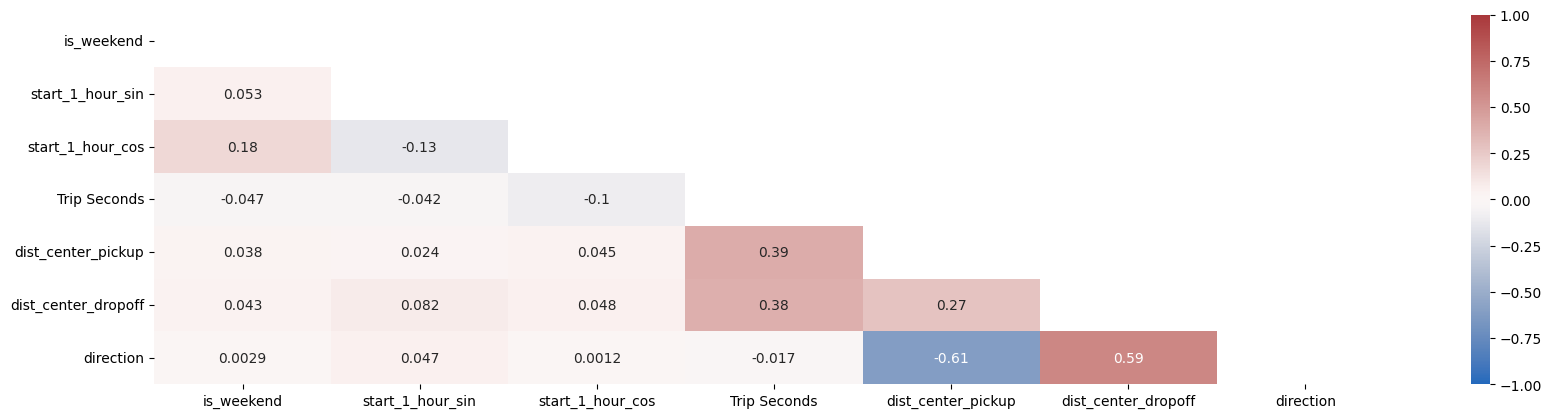

In [33]:
plt_corr(df_trips_enc_clust_scaled)

A strong correlation between direction and dist_center_pickup and dist_center_dropoff is observable. This is because of the calculation of the feature depending on the two distance features.

Calculate the optimal number of clusters using a Grid Search

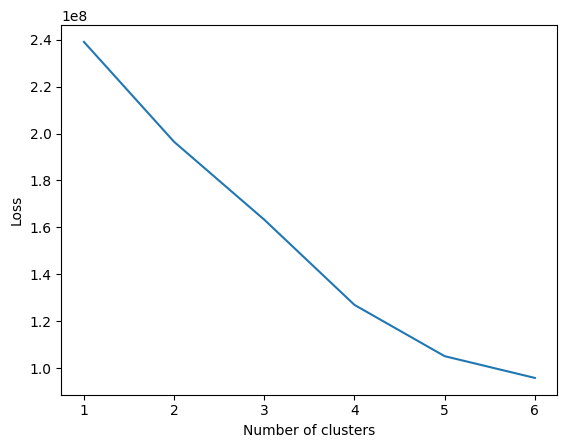

In [34]:
gridSearch(df_trips_enc_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 5.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [35]:
num_cluster = 4

#### Gaussian Mixture Model

In [36]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_trips_enc_clust_scaled, df_trips_clust)

In [37]:
df_trips_clust

is_weekend  start_1_hour  Trip Seconds  dist_center_pickup  \
0                  1            10        1080.0                   2   
2                  1            23         720.0                   5   
3                  1             1         480.0                  12   
5                  0             9         180.0                  49   
6                  1             3         840.0                  10   
...              ...           ...           ...                 ...   
37395431           0            20         900.0                  25   
37395432           0            23         540.0                   7   
37395433           0            12         240.0                   0   
37395434           0            12         360.0                   8   
37395435           0            23         840.0                   3   

          dist_center_dropoff  direction  cluster_GaussianMixture  
0                          26         24                        2  
2                           5          0                        2  
3                          24         12                        2  
5                          40         -9                        0  
6                           3         -7                        2  
...                       ...        ...                      ...  
37395431                   13        -12                        0  
37395432                   25         18                        0  
37395433                    7          7                        0  
37395434                    7         -1                        0  
37395435                   14         11                        0  

[34153067 rows x 7 columns]

In [38]:
feature_distribution(df_trips_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour            \
                              mean       std         mean       std   
cluster_GaussianMixture                                               
0                         0.000000  0.000000    14.265631  6.053811   
1                         0.197787  0.398331    11.736980  4.743902   
2                         1.000000  0.000000    11.880668  7.809547   
3                         0.195390  0.396501    14.693786  5.642560   

                        Trip Seconds             dist_center_pickup  \
                                mean         std               mean   
cluster_GaussianMixture                                               
0                         585.088892  397.007981           8.885404   
1                        2249.344652  809.716264           9.197146   
2                         608.907869  401.187468          12.110905   
3                        1901.784847  920.522300          74.369870   

                                   dist_center_dropoff             direction  \
                               std                mean        std       mean   
cluster_GaussianMixture                                                        
0                        10.675324           10.053595  11.410272   1.168191   
1                        10.587124           67.139251  22.711243  57.942105   
2                        11.226415           13.200878  11.960839   1.089973   
3                        11.762991           20.156635  25.426438 -54.213235   

                                   cluster_size first_is_weekend  \
                               std                                 
cluster_GaussianMixture                                            
0                        10.346960     21146759                0   
1                        23.645053      1454979                0   
2                        11.444874      9787409                1   
3                        26.509037      1763920                0   

                        first_start_1_hour first_Trip Seconds  \
                                                                
cluster_GaussianMixture                                         
0                                       19              360.0   
1                                       15             3660.0   
2                                        0              360.0   
3                                       20             3660.0   

                        first_dist_center_pickup first_dist_center_dropoff  \
                                                                             
cluster_GaussianMixture                                                      
0                                              0                         0   
1                                              0                        79   
2                                              4                         4   
3                                             79                         4   

                        first_direction  
                                         
cluster_GaussianMixture                  
0                                     0  
1                                    75  
2                                     0  
3                                   -75

#### KMeans

In [39]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_trips_enc_clust_scaled, df_trips_clust)

In [40]:
df_trips_clust

is_weekend  start_1_hour  Trip Seconds  dist_center_pickup  \
0                  1            10        1080.0                   2   
2                  1            23         720.0                   5   
3                  1             1         480.0                  12   
5                  0             9         180.0                  49   
6                  1             3         840.0                  10   
...              ...           ...           ...                 ...   
37395431           0            20         900.0                  25   
37395432           0            23         540.0                   7   
37395433           0            12         240.0                   0   
37395434           0            12         360.0                   8   
37395435           0            23         840.0                   3   

          dist_center_dropoff  direction  cluster_GaussianMixture  \
0                          26         24                        2   
2                           5          0                        2   
3                          24         12                        2   
5                          40         -9                        0   
6                           3         -7                        2   
...                       ...        ...                      ...   
37395431                   13        -12                        0   
37395432                   25         18                        0   
37395433                    7          7                        0   
37395434                    7         -1                        0   
37395435                   14         11                        0   

          cluster_KMeans  
0                      2  
2                      2  
3                      2  
5                      0  
6                      2  
...                  ...  
37395431               0  
37395432               0  
37395433               0  
37395434               0  
37395435               0  

[34153067 rows x 8 columns]

In [41]:
feature_distribution(df_trips_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour           Trip Seconds  \
                     mean       std         mean       std         mean   
cluster_KMeans                                                            
0                0.000000  0.000000    14.310322  6.025219   568.477130   
1                0.217720  0.412696    11.673192  5.215493  1963.716282   
2                1.000000  0.000000    11.862803  7.844999   589.849839   
3                0.211281  0.408217    14.536317  5.786329  1848.374437   

                           dist_center_pickup            dist_center_dropoff  \
                       std               mean        std                mean   
cluster_KMeans                                                                 
0               401.430965           8.340856   9.883148            9.375541   
1               762.943573          10.253518  11.356732           65.430069   
2               393.239455          11.747331  10.773823           12.738733   
3               865.742611          68.649293  16.248486           18.188647   

                           direction            cluster_size first_is_weekend  \
                      std       mean        std                                 
cluster_KMeans                                                                  
0               10.479193   1.034685   8.697524     20585838                0   
1               17.288926  55.176551  19.744751      1849676                0   
2               11.375669   0.991402   9.778988      9561619                1   
3               22.778863 -50.460646  25.148682      2155934                0   

               first_start_1_hour first_Trip Seconds first_dist_center_pickup  \
                                                                                
cluster_KMeans                                                                  
0                              19              360.0                        0   
1                               6             3660.0                        4   
2                               0              360.0                        4   
3                              20             3660.0                       79   

               first_dist_center_dropoff first_direction  
                                                          
cluster_KMeans                                            
0                                      0               0  
1                                     79              75  
2                                      4               0  
3                                      4             -75

#### Evaluation

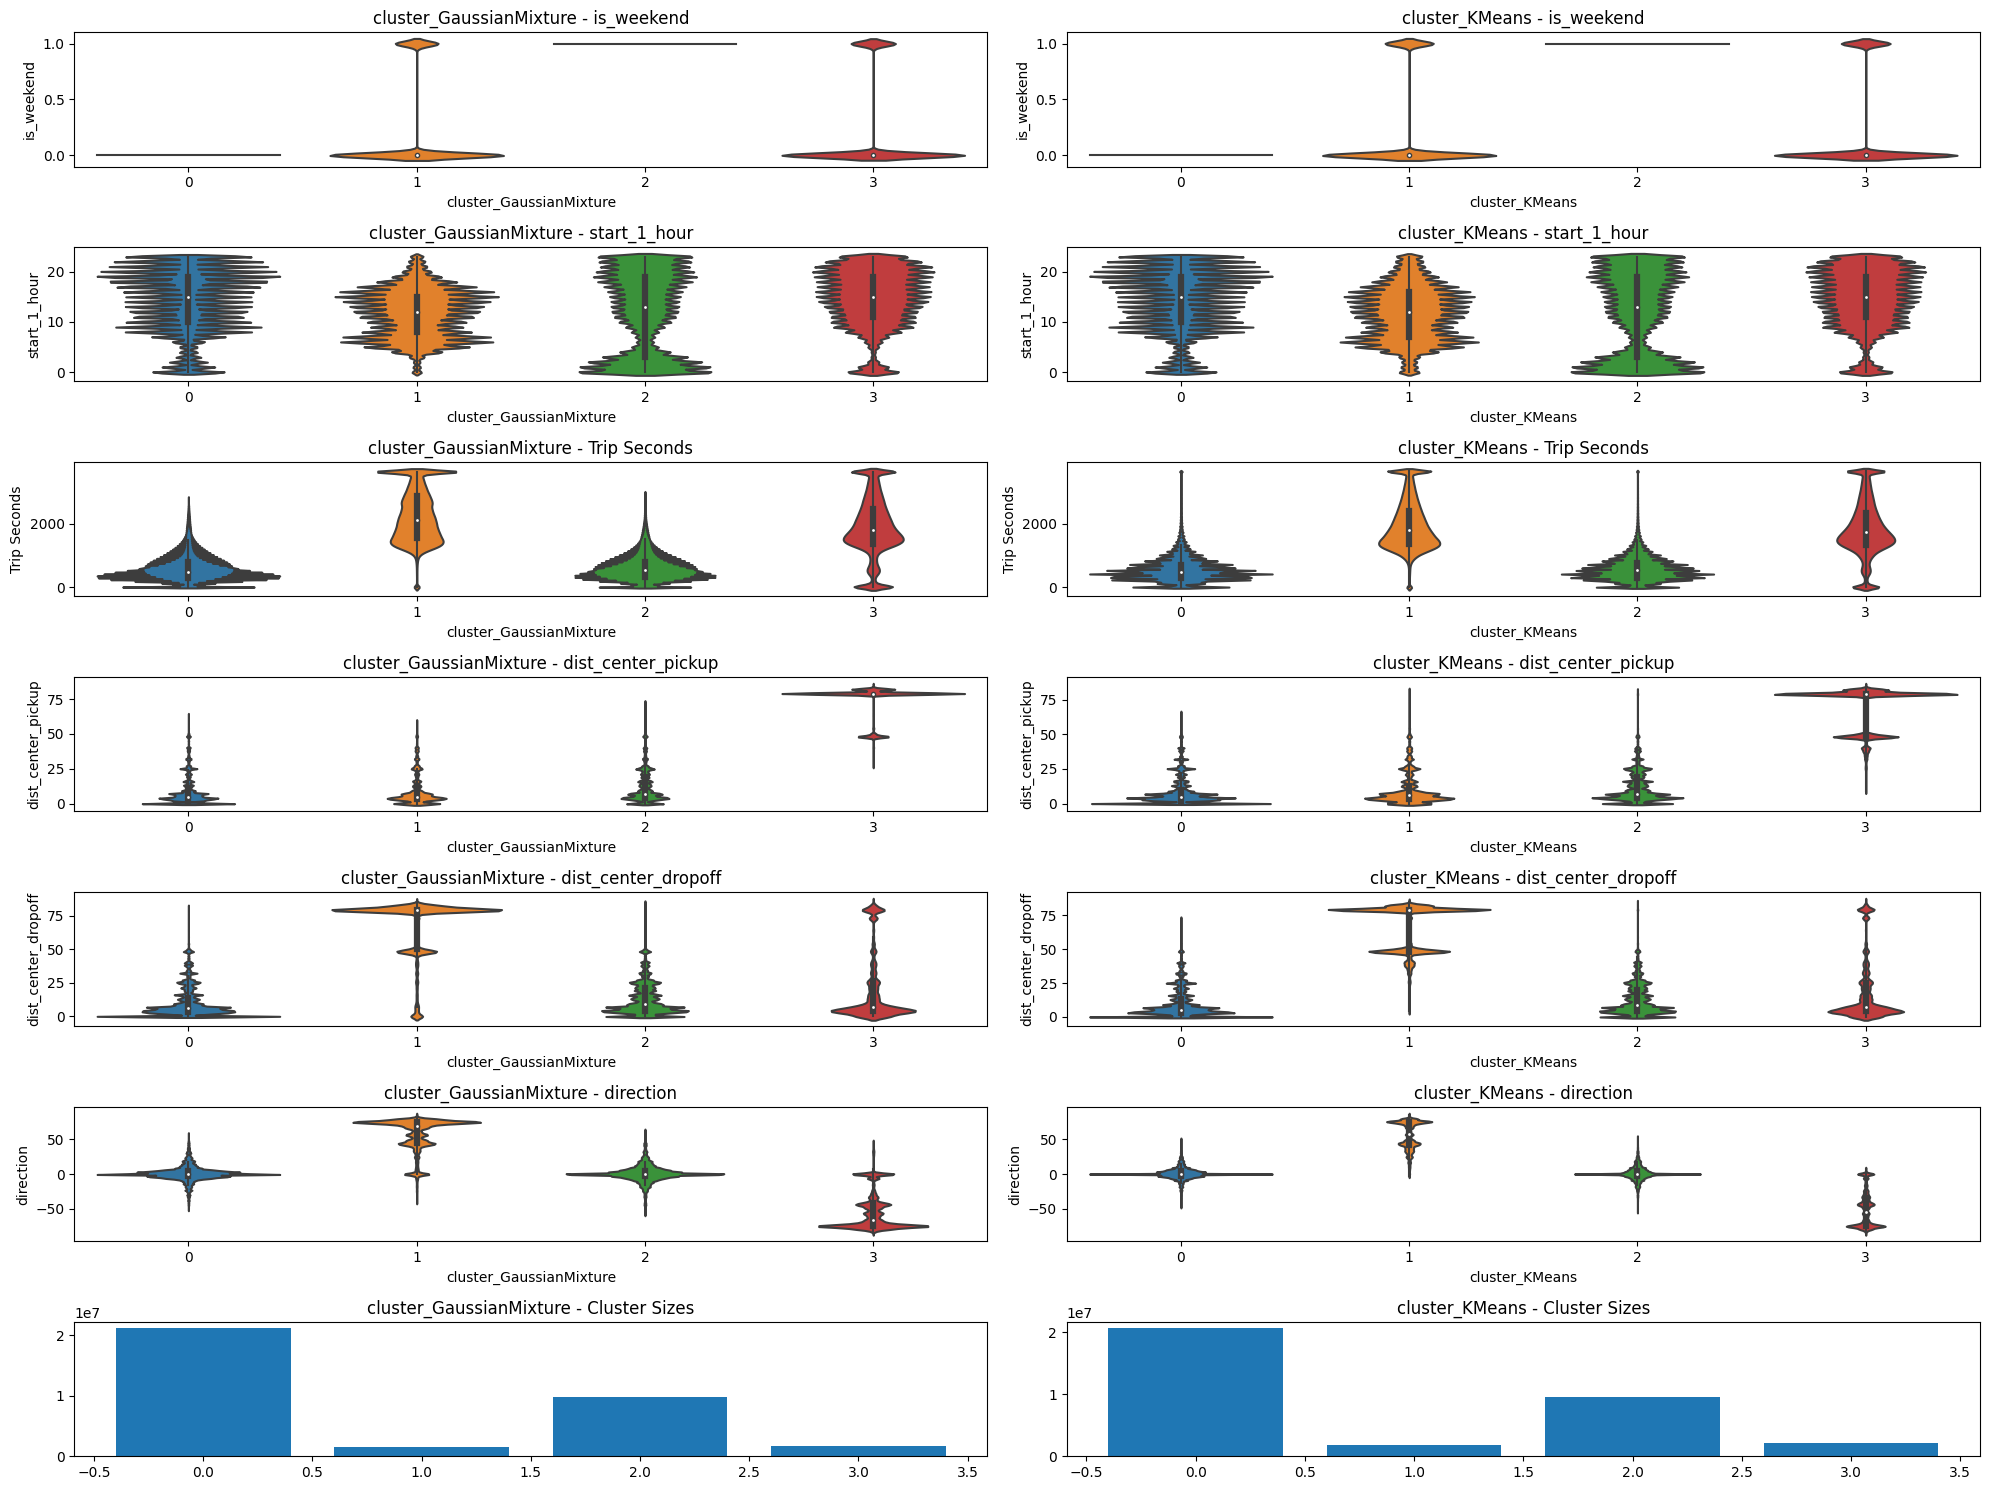

In [42]:
plt_violins(df_trips_clust)

## Trip/Customer clustering

Clustering based on customer specific features.

In [43]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [44]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [45]:
# Clustering features
trips_customer_clust_feat     = ['is_weekend',  'start_1_hour', 'Trip Total', 'Payment Type_Credit Card']
# Encoded features
trips_customer_enc_clust_feat = ['is_weekend',  'start_1_hour_sin', 'Trip Total', 'Payment Type_Credit Card']

df_trips_customer_clust = df_trips[trips_customer_clust_feat]
df_trips_customer_enc_clust = df_trips[trips_customer_enc_clust_feat]

Scale encoded dataframe

In [46]:
df_trips_customer_enc_clust_scaled = scale_df(df_trips_customer_enc_clust)

Plot correlation matrix to check for depended features

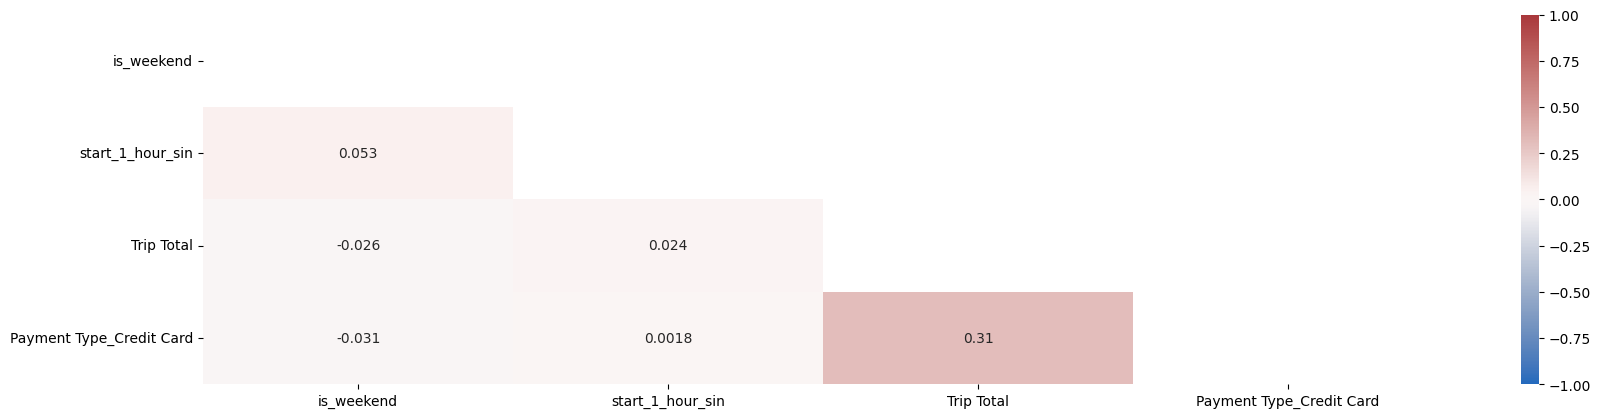

In [47]:
plt_corr(df_trips_customer_enc_clust_scaled)

A strong correlation between direction and dist_center_pickup and dist_center_dropoff is observable. This is because of the calculation of the feature depending on the two distance features.

Calculate the optimal number of clusters using a Grid Search

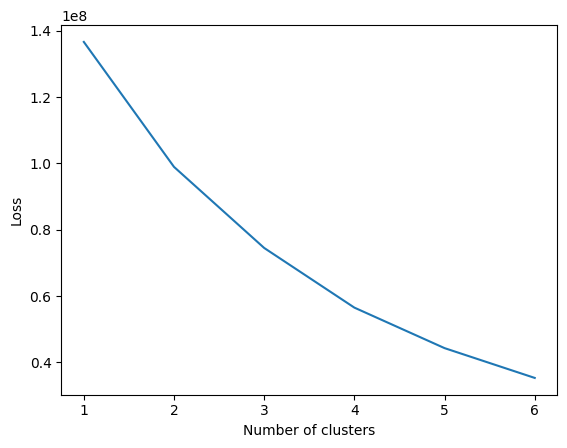

In [48]:
gridSearch(df_trips_customer_enc_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [49]:
num_cluster = 2

#### Gaussian Mixture Model

In [50]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_trips_customer_enc_clust_scaled, df_trips_customer_clust)

In [51]:
df_trips_customer_clust

is_weekend  start_1_hour  Trip Total  Payment Type_Credit Card  \
0                  1            10       18.95                       0.0   
2                  1            23       11.45                       1.0   
3                  1             1       11.85                       1.0   
5                  0             9        5.05                       0.0   
6                  1             3        9.85                       0.0   
...              ...           ...         ...                       ...   
37395431           0            20       11.25                       0.0   
37395432           0            23       15.40                       1.0   
37395433           0            12        9.75                       1.0   
37395434           0            12        5.05                       0.0   
37395435           0            23       13.70                       1.0   

          cluster_GaussianMixture  
0                               0  
2                               1  
3                               1  
5                               0  
6                               0  
...                           ...  
37395431                        0  
37395432                        1  
37395433                        1  
37395434                        0  
37395435                        1  

[34153067 rows x 5 columns]

In [52]:
feature_distribution(df_trips_customer_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour            \
                              mean       std         mean       std   
cluster_GaussianMixture                                               
0                         0.314968  0.464503    13.486855  6.637276   
1                         0.284228  0.451046    13.517029  6.646596   

                        Trip Total            Payment Type_Credit Card       \
                              mean        std                     mean  std   
cluster_GaussianMixture                                                       
0                        10.600258   8.428695                      0.0  0.0   
1                        17.916032  13.625319                      1.0  0.0   

                        cluster_size first_is_weekend first_start_1_hour  \
                                                                           
cluster_GaussianMixture                                                    
0                           23180477                0                 19   
1                           10972590                0                 19   

                        first_Trip Total first_Payment Type_Credit Card  
                                                                         
cluster_GaussianMixture                                                  
0                                   3.25                            0.0  
1                                   8.65                            1.0

#### KMeans

In [53]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_trips_customer_enc_clust_scaled, df_trips_customer_clust)

In [54]:
df_trips_customer_clust

is_weekend  start_1_hour  Trip Total  Payment Type_Credit Card  \
0                  1            10       18.95                       0.0   
2                  1            23       11.45                       1.0   
3                  1             1       11.85                       1.0   
5                  0             9        5.05                       0.0   
6                  1             3        9.85                       0.0   
...              ...           ...         ...                       ...   
37395431           0            20       11.25                       0.0   
37395432           0            23       15.40                       1.0   
37395433           0            12        9.75                       1.0   
37395434           0            12        5.05                       0.0   
37395435           0            23       13.70                       1.0   

          cluster_GaussianMixture  cluster_KMeans  
0                               0               0  
2                               1               1  
3                               1               1  
5                               0               0  
6                               0               0  
...                           ...             ...  
37395431                        0               0  
37395432                        1               1  
37395433                        1               1  
37395434                        0               0  
37395435                        1               1  

[34153067 rows x 6 columns]

In [55]:
feature_distribution(df_trips_customer_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour           Trip Total  \
                     mean       std         mean       std       mean   
cluster_KMeans                                                          
0                0.315376  0.464665    13.489402  6.640132  10.364301   
1                0.283686  0.450786    13.511426  6.640584  18.334568   

                          Payment Type_Credit Card           cluster_size  \
                      std                     mean       std                
cluster_KMeans                                                              
0                7.693286                  0.00000  0.000000     23070421   
1               14.221310                  0.99007  0.099156     11082646   

               first_is_weekend first_start_1_hour first_Trip Total  \
                                                                      
cluster_KMeans                                                        
0                             0                 19             3.25   
1                             0                 19             8.65   

               first_Payment Type_Credit Card  
                                               
cluster_KMeans                                 
0                                         0.0  
1                                         1.0

#### Evaluation

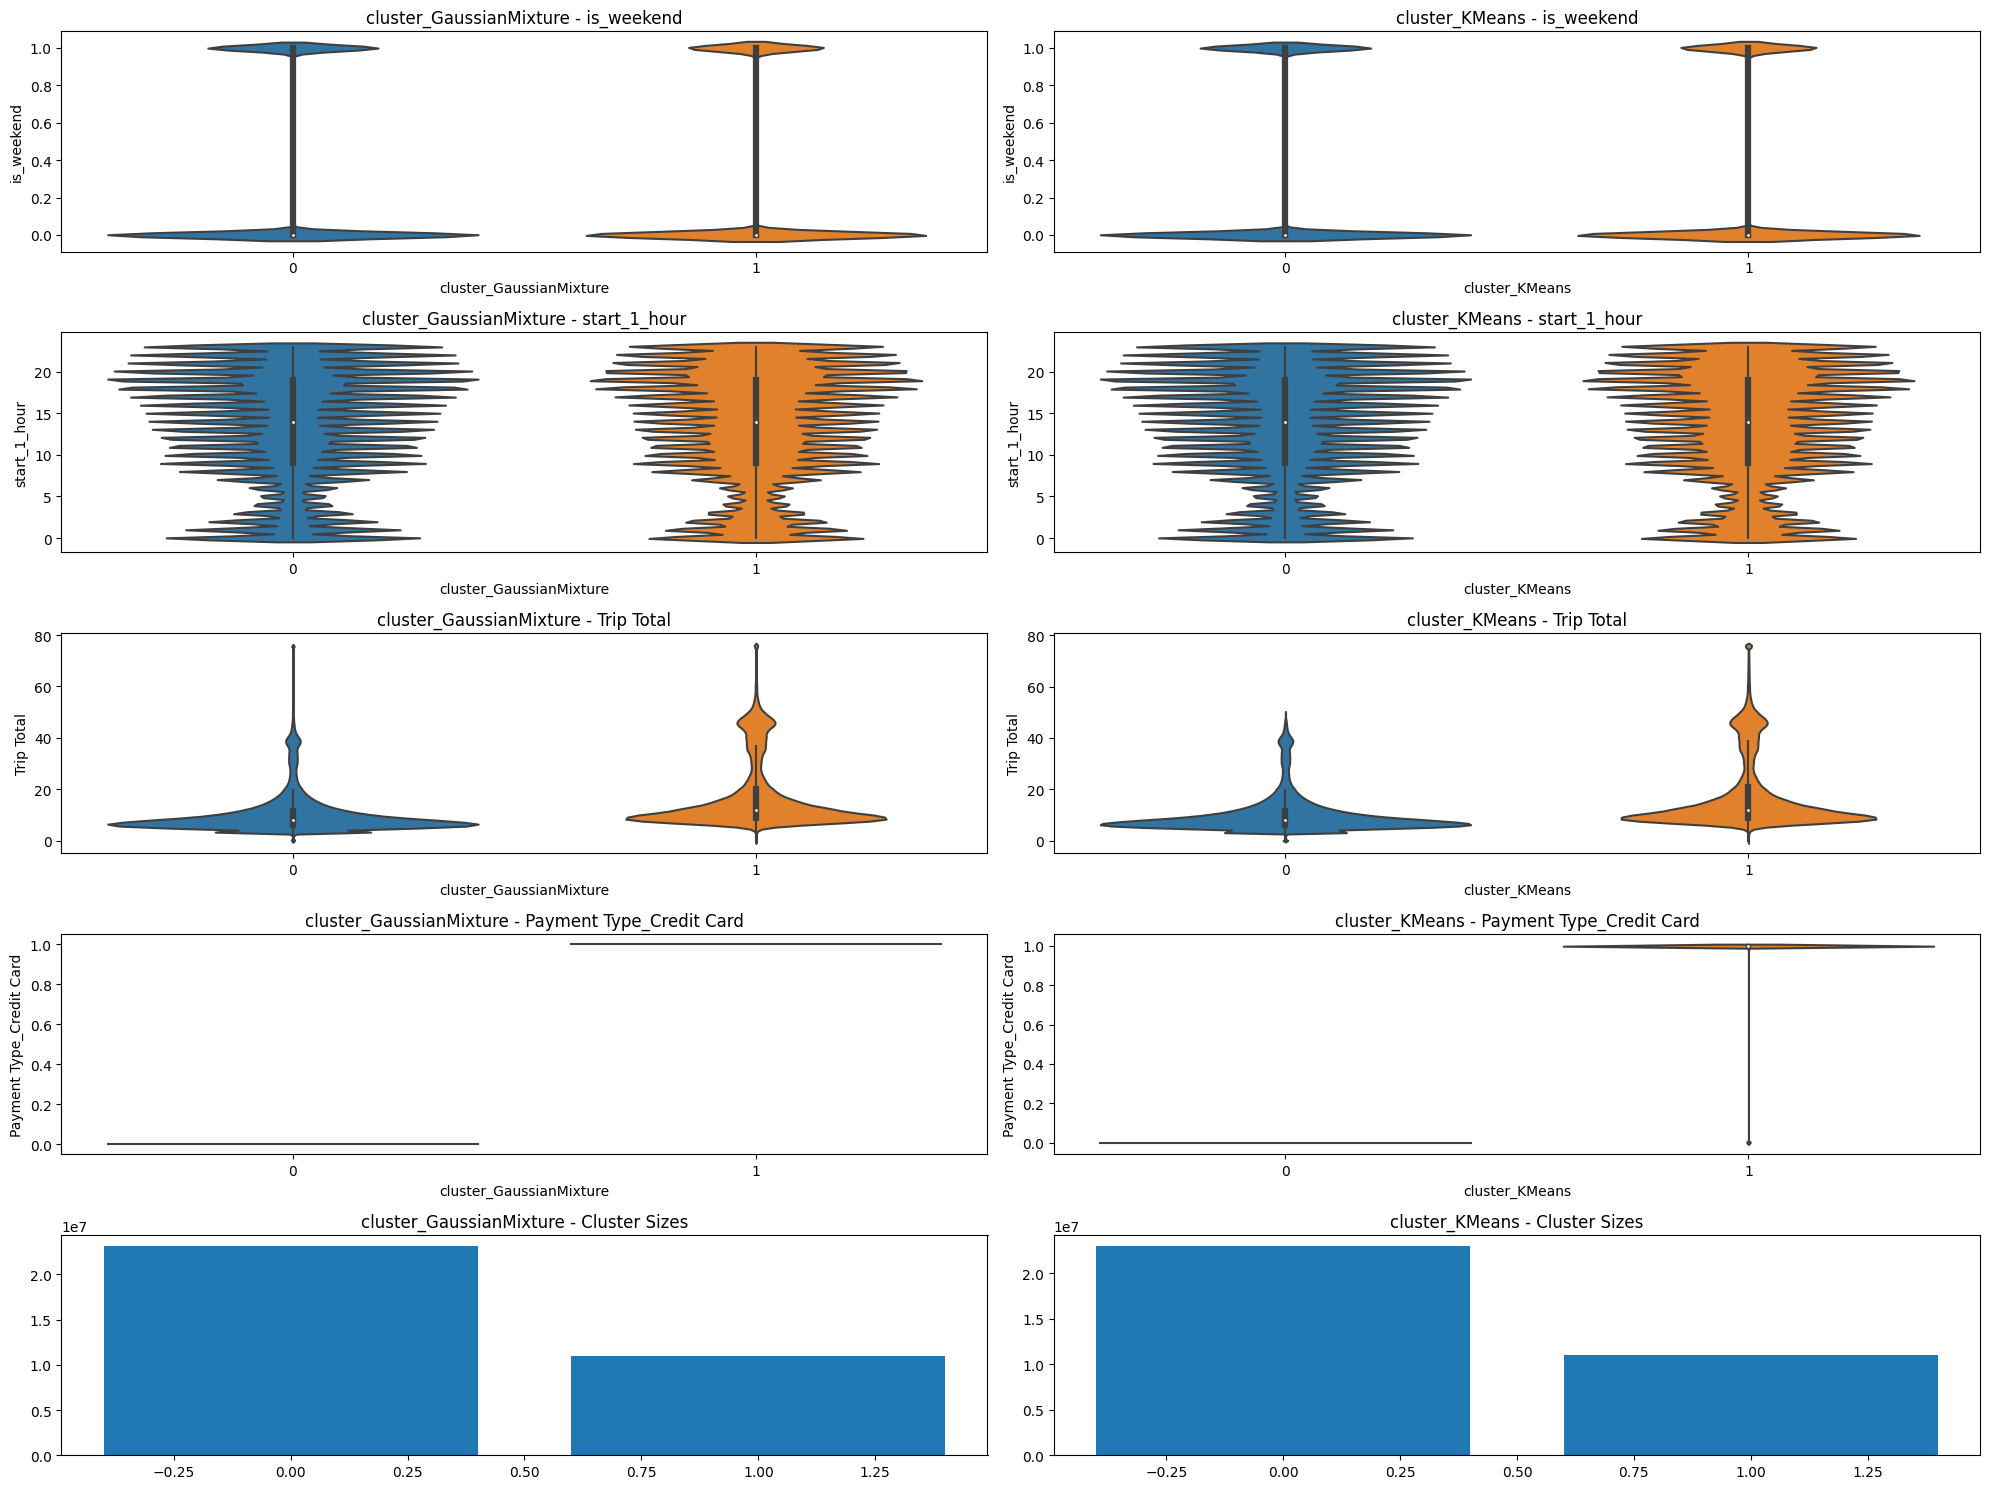

In [56]:
plt_violins(df_trips_customer_clust)

# Weather-based clustering

## Weather clustering

Clustering based on same features as trip clustering enhanced by weather feature

In [57]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [58]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [59]:
# Clustering features
trips_clust_feat     = ['ts_start_1_hour', 'is_weekend',  'start_1_hour', 'Trip Seconds']
# Encoded features
trips_enc_clust_feat = ['ts_start_1_hour', 'is_weekend',  'start_1_hour_sin', 'start_1_hour_cos', 'Trip Seconds']

df_trips_clust = df_trips[trips_clust_feat]
df_trips_enc_clust = df_trips[trips_enc_clust_feat]

In [60]:
df_weather

Temperature  Precip.  cloud
datetime                                        
2014-01-01 00:00:00        -10.0      0.0    3.0
2014-01-01 01:00:00         -8.9      0.0    3.0
2014-01-01 02:00:00         -8.3      0.0    3.0
2014-01-01 03:00:00         -7.8      0.0    3.0
2014-01-01 04:00:00         -7.2      0.0    3.0
...                          ...      ...    ...
2014-12-31 19:00:00         -7.2      0.0    0.0
2014-12-31 20:00:00         -7.2      0.0    0.0
2014-12-31 21:00:00         -6.7      0.0    0.0
2014-12-31 22:00:00         -6.7      0.0    0.0
2014-12-31 23:00:00         -6.7      0.0    0.0

[8760 rows x 3 columns]

Joining trips and weather data

In [61]:
df_weather_clust = df_trips_clust.merge(df_weather, left_on='ts_start_1_hour', right_on='datetime', how='left')
df_weather_enc_clust = df_trips_enc_clust.merge(df_weather, left_on='ts_start_1_hour', right_on='datetime', how='left')

df_weather_clust.drop(columns=['ts_start_1_hour'], inplace=True)
df_weather_enc_clust.drop(columns=['ts_start_1_hour'], inplace=True)

In [62]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud
0                  1            10        1080.0         12.2      0.0    2.0
1                  1            23         720.0         16.7      0.0    3.0
2                  1             1         480.0          6.7      0.0    3.0
3                  0             9         180.0         13.3      0.0    3.0
4                  1             3         840.0         13.3      0.0    1.0
...              ...           ...           ...          ...      ...    ...
34153062           0            20         900.0          3.9      0.0    0.0
34153063           0            23         540.0         12.8      0.0    3.0
34153064           0            12         240.0         13.3      0.0    3.0
34153065           0            12         360.0         13.3      0.0    3.0
34153066           0            23         840.0         12.8      0.0    3.0

[34153067 rows x 6 columns]

Scale encoded dataframe

In [63]:
df_weather_enc_clust_scaled = scale_df(df_weather_enc_clust)

Plot correlation matrix to check for depended features

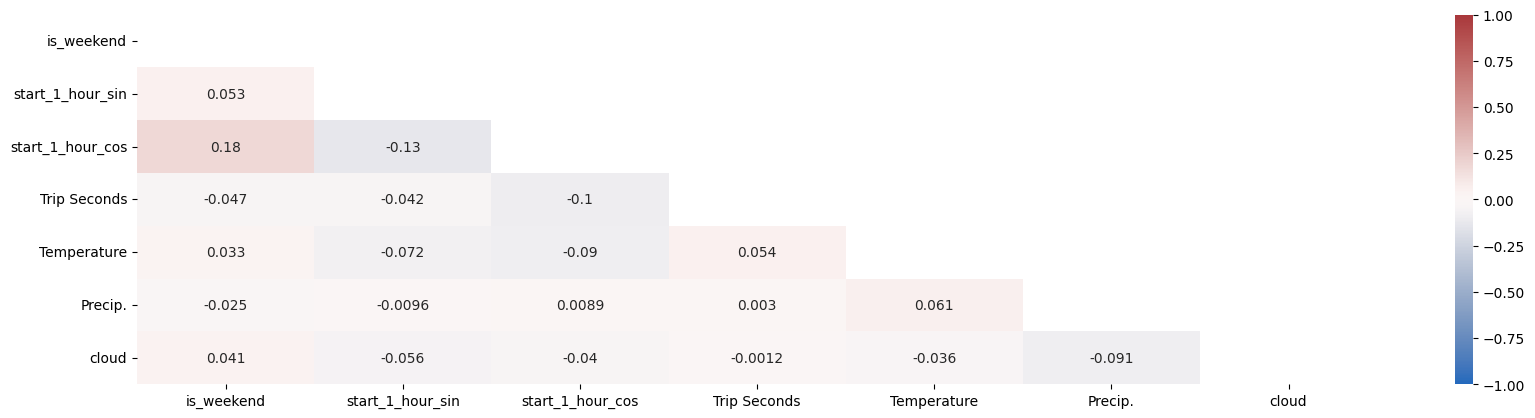

In [64]:
plt_corr(df_weather_enc_clust_scaled)

A strong correlation between direction and dist_center_pickup and dist_center_dropoff is observable. This is because of the calculation of the feature depending on the two distance features.

Calculate the optimal number of clusters using a Grid Search

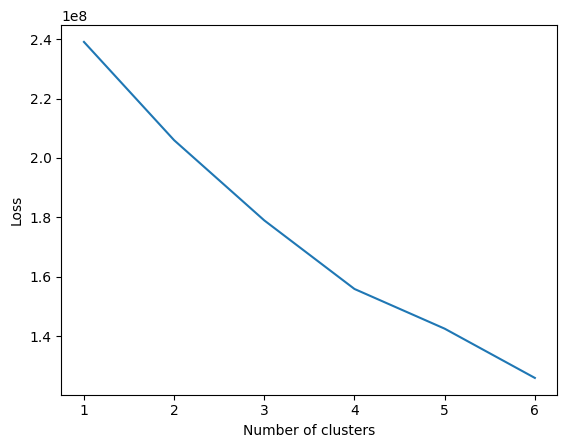

In [65]:
gridSearch(df_weather_enc_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 4.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [66]:
num_cluster = 2

#### Gaussian Mixture Model

In [67]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_weather_enc_clust_scaled, df_weather_clust)

In [68]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud  \
0                  1            10        1080.0         12.2      0.0    2.0   
1                  1            23         720.0         16.7      0.0    3.0   
2                  1             1         480.0          6.7      0.0    3.0   
3                  0             9         180.0         13.3      0.0    3.0   
4                  1             3         840.0         13.3      0.0    1.0   
...              ...           ...           ...          ...      ...    ...   
34153062           0            20         900.0          3.9      0.0    0.0   
34153063           0            23         540.0         12.8      0.0    3.0   
34153064           0            12         240.0         13.3      0.0    3.0   
34153065           0            12         360.0         13.3      0.0    3.0   
34153066           0            23         840.0         12.8      0.0    3.0   

          cluster_GaussianMixture  
0                               0  
1                               0  
2                               0  
3                               0  
4                               0  
...                           ...  
34153062                        0  
34153063                        0  
34153064                        0  
34153065                        0  
34153066                        0  

[34153067 rows x 7 columns]

In [69]:
feature_distribution(df_weather_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour            \
                              mean       std         mean       std   
cluster_GaussianMixture                                               
0                         0.307087  0.461286    13.493052  6.637161   
1                         0.201736  0.401297    13.677767  6.797853   

                        Trip Seconds             Temperature             \
                                mean         std        mean        std   
cluster_GaussianMixture                                                   
0                         730.361201  632.773857   11.206619  12.171132   
1                         754.544656  691.036581   16.375812   7.245260   

                          Precip.               cloud           cluster_size  \
                             mean       std      mean       std                
cluster_GaussianMixture                                                        
0                        0.000000  0.000000  1.619882  1.219576     33506565   
1                        0.202604  0.189578  0.637853  1.201894       646502   

                        first_is_weekend first_start_1_hour  \
                                                              
cluster_GaussianMixture                                       
0                                      0                 19   
1                                      0                 19   

                        first_Trip Seconds first_Temperature first_Precip.  \
                                                                             
cluster_GaussianMixture                                                      
0                                    360.0              22.8           0.0   
1                                    360.0              22.8           0.1   

                        first_cloud  
                                     
cluster_GaussianMixture              
0                               3.0  
1                               0.0

#### KMeans

In [70]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_weather_enc_clust_scaled, df_weather_clust)

In [71]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud  \
0                  1            10        1080.0         12.2      0.0    2.0   
1                  1            23         720.0         16.7      0.0    3.0   
2                  1             1         480.0          6.7      0.0    3.0   
3                  0             9         180.0         13.3      0.0    3.0   
4                  1             3         840.0         13.3      0.0    1.0   
...              ...           ...           ...          ...      ...    ...   
34153062           0            20         900.0          3.9      0.0    0.0   
34153063           0            23         540.0         12.8      0.0    3.0   
34153064           0            12         240.0         13.3      0.0    3.0   
34153065           0            12         360.0         13.3      0.0    3.0   
34153066           0            23         840.0         12.8      0.0    3.0   

          cluster_GaussianMixture  cluster_KMeans  
0                               0               0  
1                               0               1  
2                               0               1  
3                               0               0  
4                               0               1  
...                           ...             ...  
34153062                        0               1  
34153063                        0               1  
34153064                        0               0  
34153065                        0               0  
34153066                        0               1  

[34153067 rows x 8 columns]

In [72]:
feature_distribution(df_weather_clust, f'cluster_{model.__class__.__name__}')

is_weekend           start_1_hour           Trip Seconds  \
                     mean       std         mean       std         mean   
cluster_KMeans                                                            
0                0.200867  0.400649    11.212390  3.056547   828.940409   
1                0.386782  0.487013    15.286838  8.002264   653.912897   

                           Temperature              Precip.            \
                       std        mean        std      mean       std   
cluster_KMeans                                                          
0               756.818756   12.375527  12.552892  0.003208  0.033097   
1               504.443585   10.464992  11.695744  0.004327  0.041403   

                   cloud           cluster_size first_is_weekend  \
                    mean       std                                 
cluster_KMeans                                                     
0               1.603693  1.196534     15006662                0   
1               1.599412  1.249597     19146405                0   

               first_start_1_hour first_Trip Seconds first_Temperature  \
                                                                         
cluster_KMeans                                                           
0                              13              360.0              25.6   
1                              19              360.0              22.8   

               first_Precip. first_cloud  
                                          
cluster_KMeans                            
0                        0.0         3.0  
1                        0.0         3.0

#### Evaluation

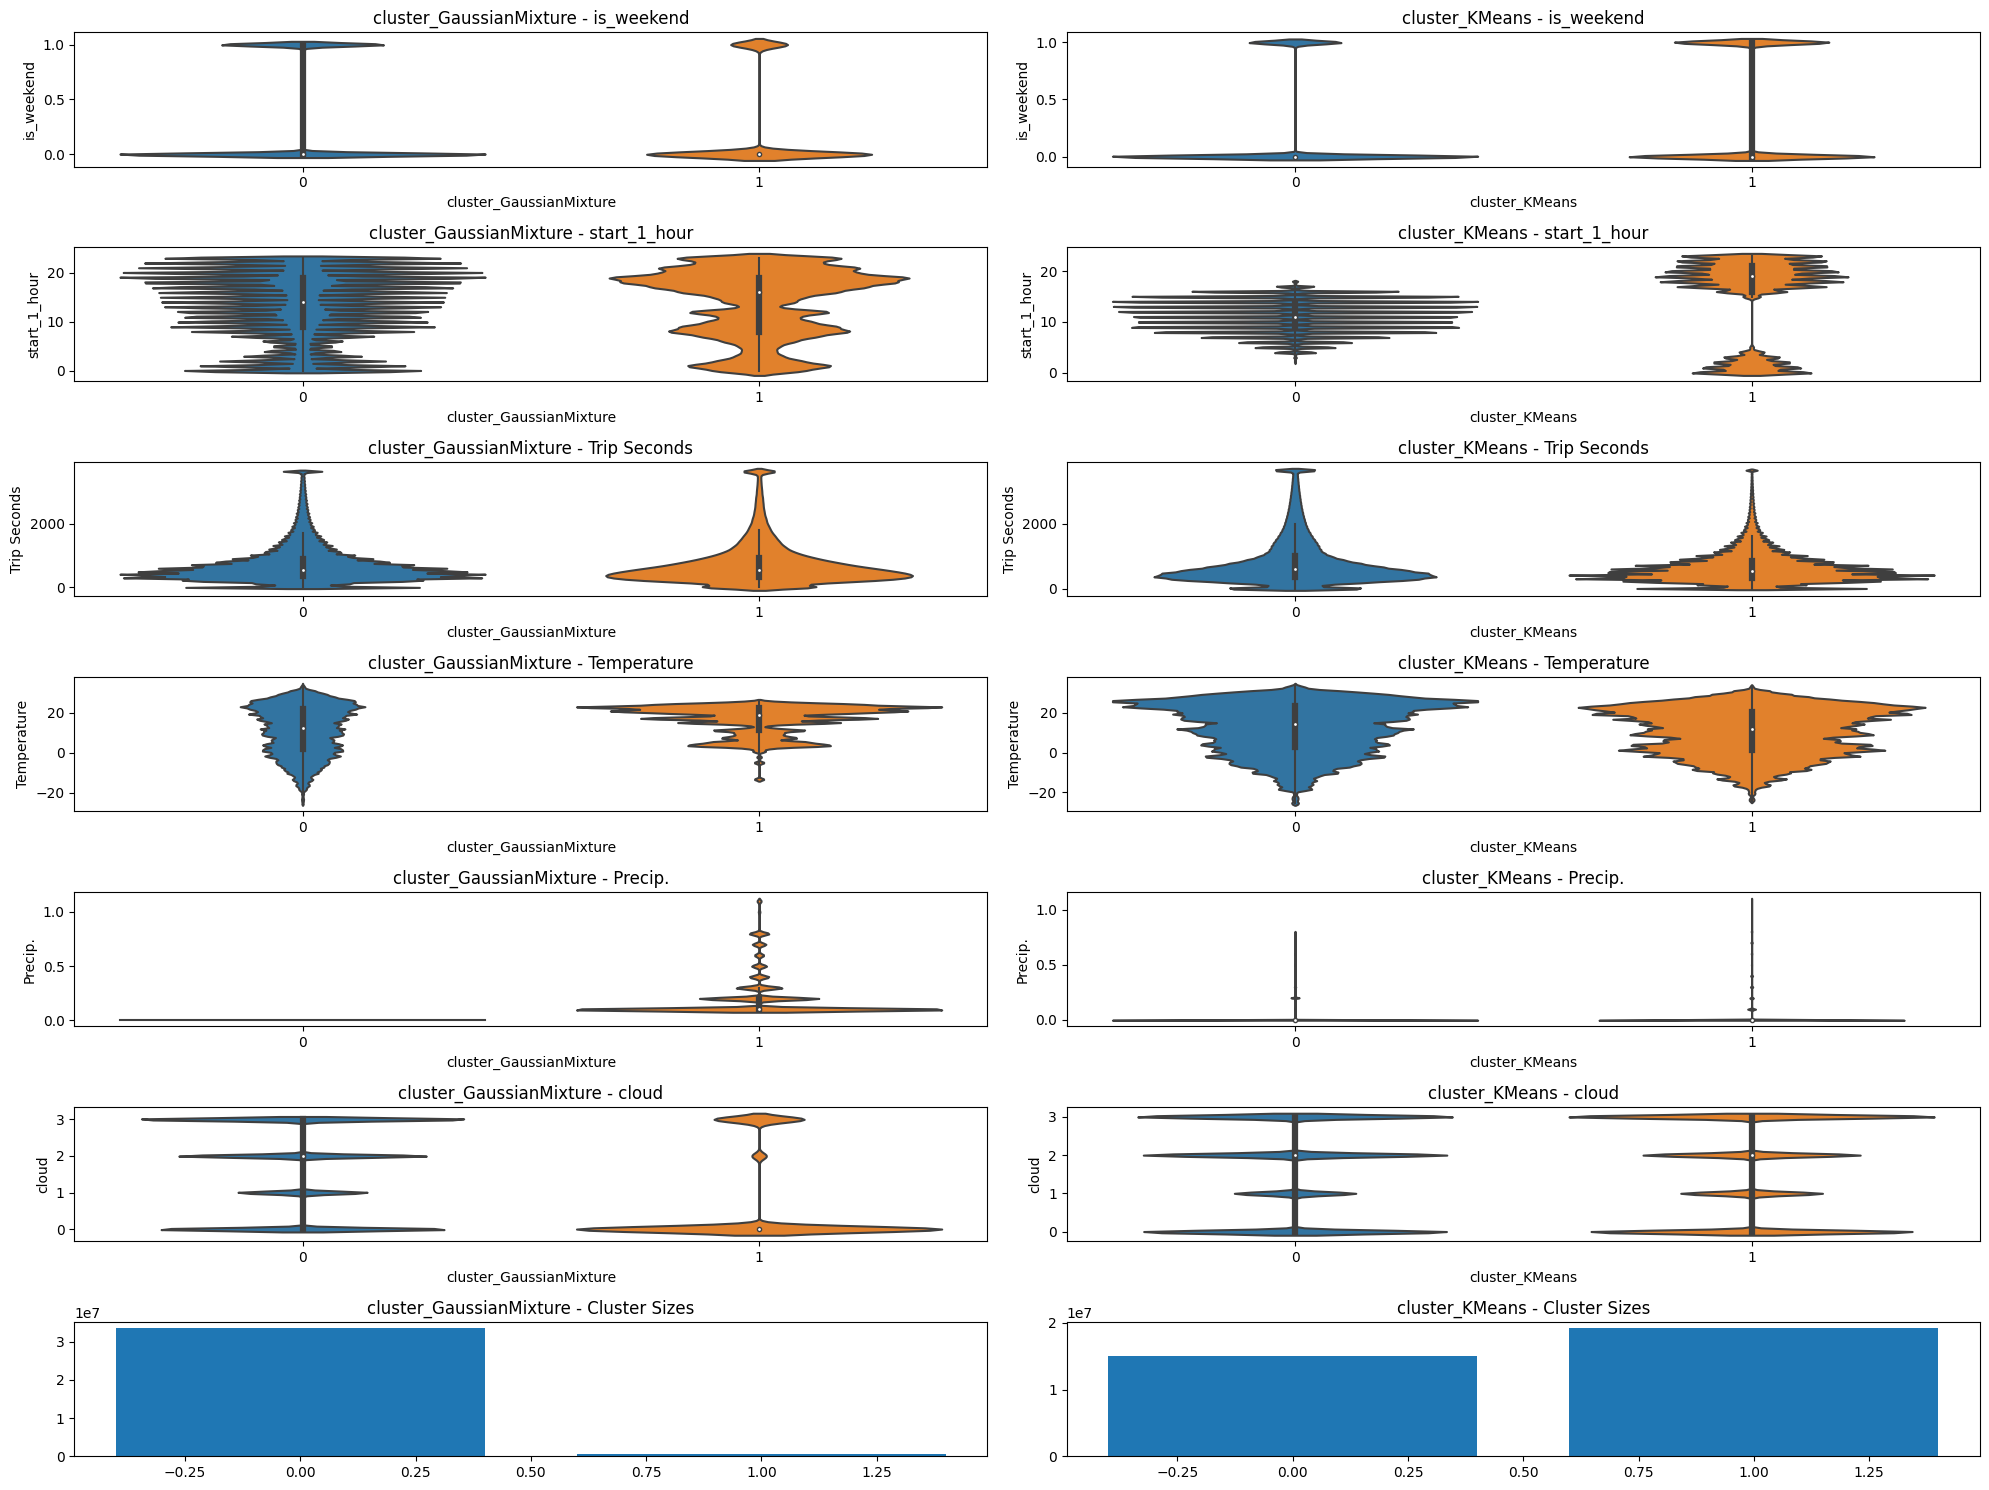

In [73]:
plt_violins(df_weather_clust)

# Hexagon-based clustering

## Hexagon demand clustering

Clustering based on same features as trip clustering enhanced by weather feature

In [74]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [75]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [76]:
# Aggregate trips based on start_hour and hexagon ID
df_hex_pickup_clust = df_trips.groupby(by=['start_1_hour', f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour']

# unstack to retrieve demand in each hour as feature for each hexagon and fill resulting nan values with demand of zero
df_hex_pickup_clust = df_hex_pickup_clust.unstack(0)
df_hex_pickup_clust = df_hex_pickup_clust.fillna(0)

# rename columns
df_hex_pickup_clust.columns = df_hex_pickup_clust.columns.map(str)

df_hex_pickup_clust

start_1_hour        0     1     2     3     4     5     6      7      8  \
pickup_hex_9                                                              
89266419157ffff   6.0   1.0   1.0   8.0   4.0   5.0   3.0   12.0    6.0   
89266419493ffff   6.0   9.0   6.0   9.0   6.0   9.0   6.0    9.0   12.0   
89266419607ffff  11.0  15.0  10.0  23.0  11.0  13.0  23.0   51.0   54.0   
8926641962fffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
8926645204fffff   0.0   0.0   0.0   0.0   0.0   0.0   1.0    0.0    0.0   
...               ...   ...   ...   ...   ...   ...   ...    ...    ...   
89275936b77ffff   1.0   0.0   0.0   1.0   0.0   3.0   4.0    0.0    1.0   
89275936bb3ffff   0.0   0.0   0.0   0.0   0.0   4.0  14.0    1.0    1.0   
89275936bc7ffff   6.0   1.0   7.0   0.0   0.0  10.0  43.0   73.0  132.0   
89275936d37ffff   3.0   0.0   2.0   1.0   1.0   0.0   0.0    3.0    3.0   
89275936d53ffff  69.0  99.0  96.0  76.0  61.0  74.0  85.0  181.0   55.0   

start_1_hour         9  ...    14     15     16    17     18    19    20  \
pickup_hex_9            ...                                                
89266419157ffff   11.0  ...   9.0   13.0    7.0   5.0   10.0   9.0   8.0   
89266419493ffff    9.0  ...  16.0    8.0   10.0  10.0   12.0  14.0   9.0   
89266419607ffff  107.0  ...  58.0   88.0  130.0  29.0   23.0  26.0  22.0   
8926641962fffff    0.0  ...   0.0    0.0    0.0   0.0    0.0   0.0   0.0   
8926645204fffff    0.0  ...   0.0    0.0    0.0   0.0    0.0   0.0   0.0   
...                ...  ...   ...    ...    ...   ...    ...   ...   ...   
89275936b77ffff    0.0  ...   6.0    5.0    2.0   8.0    0.0   0.0   2.0   
89275936bb3ffff    0.0  ...   7.0    3.0    7.0   8.0    7.0   2.0   1.0   
89275936bc7ffff  124.0  ...  46.0  104.0  127.0  94.0  119.0  61.0  24.0   
89275936d37ffff    0.0  ...   0.0    4.0    0.0   0.0    2.0   0.0   0.0   
89275936d53ffff   54.0  ...  45.0   38.0   38.0  45.0   48.0  54.0  42.0   

start_1_hour       21    22    23  
pickup_hex_9                       
89266419157ffff   2.0   4.0   2.0  
89266419493ffff   9.0   5.0   4.0  
89266419607ffff  18.0  22.0   8.0  
8926641962fffff   0.0   0.0   0.0  
8926645204fffff   0.0   0.0   0.0  
...               ...   ...   ...  
89275936b77ffff   3.0   1.0   0.0  
89275936bb3ffff   4.0   3.0   3.0  
89275936bc7ffff   9.0   7.0   9.0  
89275936d37ffff   6.0   1.0   0.0  
89275936d53ffff  45.0  58.0  66.0  

[685 rows x 24 columns]

Scale encoded dataframe

In [77]:
df_hex_pickup_clust_scaled = scale_df(df_hex_pickup_clust)

Calculate the optimal number of clusters using a Grid Search

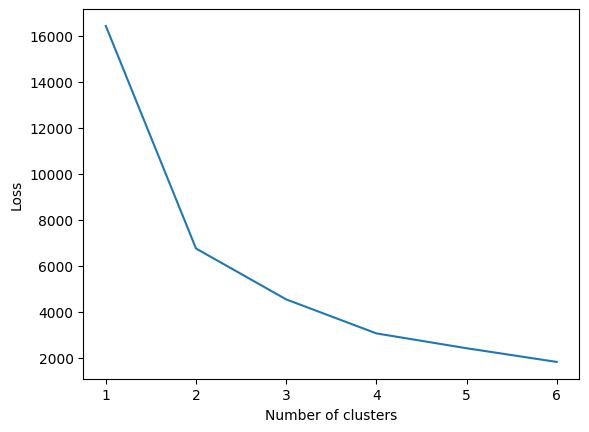

In [78]:
gridSearch(df_hex_pickup_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [79]:
num_cluster = 2

#### Gaussian Mixture Model

In [80]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_pickup_clust_scaled, df_hex_pickup_clust)

In [81]:
df_weather_clust

is_weekend  start_1_hour  Trip Seconds  Temperature  Precip.  cloud  \
0                  1            10        1080.0         12.2      0.0    2.0   
1                  1            23         720.0         16.7      0.0    3.0   
2                  1             1         480.0          6.7      0.0    3.0   
3                  0             9         180.0         13.3      0.0    3.0   
4                  1             3         840.0         13.3      0.0    1.0   
...              ...           ...           ...          ...      ...    ...   
34153062           0            20         900.0          3.9      0.0    0.0   
34153063           0            23         540.0         12.8      0.0    3.0   
34153064           0            12         240.0         13.3      0.0    3.0   
34153065           0            12         360.0         13.3      0.0    3.0   
34153066           0            23         840.0         12.8      0.0    3.0   

          cluster_GaussianMixture  cluster_KMeans  
0                               0               0  
1                               0               1  
2                               0               1  
3                               0               0  
4                               0               1  
...                           ...             ...  
34153062                        0               1  
34153063                        0               1  
34153064                        0               0  
34153065                        0               0  
34153066                        0               1  

[34153067 rows x 8 columns]

In [82]:
feature_distribution(df_hex_pickup_clust, f'cluster_{model.__class__.__name__}')

start_1_hour                        0                           1  \
                                 mean           std          mean   
cluster_GaussianMixture                                             
0                         1114.276786   3267.699418    959.183036   
1                        45148.153846  25415.694170  37167.153846   

start_1_hour                                      2                \
                                  std          mean           std   
cluster_GaussianMixture                                             
0                         2932.035028    762.177083   2487.804781   
1                        26729.936273  29761.692308  25791.183424   

start_1_hour                       3                           4  \
                                mean           std          mean   
cluster_GaussianMixture                                            
0                          525.08631   1780.200483    321.532738   
1                        23043.00000  21000.195701  17831.384615   

start_1_hour                           ... first_14 first_15 first_16  \
                                  std  ...                              
cluster_GaussianMixture                ...                              
0                         1187.643079  ...      0.0      0.0      0.0   
1                        17261.746747  ...  26793.0  27437.0  27633.0   

start_1_hour            first_17 first_18 first_19 first_20 first_21 first_22  \
                                                                                
cluster_GaussianMixture                                                         
0                            0.0      0.0      0.0      0.0      0.0      0.0   
1                        28665.0  29904.0  30731.0  31330.0  32891.0  35328.0   

start_1_hour            first_23  
                                  
cluster_GaussianMixture           
0                            0.0  
1                        37201.0  

[2 rows x 73 columns]

#### KMeans

In [83]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_pickup_clust_scaled, df_hex_pickup_clust)

In [84]:
df_hex_pickup_clust

start_1_hour        0     1     2     3     4     5     6      7      8  \
pickup_hex_9                                                              
89266419157ffff   6.0   1.0   1.0   8.0   4.0   5.0   3.0   12.0    6.0   
89266419493ffff   6.0   9.0   6.0   9.0   6.0   9.0   6.0    9.0   12.0   
89266419607ffff  11.0  15.0  10.0  23.0  11.0  13.0  23.0   51.0   54.0   
8926641962fffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
8926645204fffff   0.0   0.0   0.0   0.0   0.0   0.0   1.0    0.0    0.0   
...               ...   ...   ...   ...   ...   ...   ...    ...    ...   
89275936b77ffff   1.0   0.0   0.0   1.0   0.0   3.0   4.0    0.0    1.0   
89275936bb3ffff   0.0   0.0   0.0   0.0   0.0   4.0  14.0    1.0    1.0   
89275936bc7ffff   6.0   1.0   7.0   0.0   0.0  10.0  43.0   73.0  132.0   
89275936d37ffff   3.0   0.0   2.0   1.0   1.0   0.0   0.0    3.0    3.0   
89275936d53ffff  69.0  99.0  96.0  76.0  61.0  74.0  85.0  181.0   55.0   

start_1_hour         9  ...     16    17     18    19    20    21    22    23  \
pickup_hex_9            ...                                                     
89266419157ffff   11.0  ...    7.0   5.0   10.0   9.0   8.0   2.0   4.0   2.0   
89266419493ffff    9.0  ...   10.0  10.0   12.0  14.0   9.0   9.0   5.0   4.0   
89266419607ffff  107.0  ...  130.0  29.0   23.0  26.0  22.0  18.0  22.0   8.0   
8926641962fffff    0.0  ...    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   
8926645204fffff    0.0  ...    0.0   0.0    0.0   0.0   0.0   0.0   0.0   0.0   
...                ...  ...    ...   ...    ...   ...   ...   ...   ...   ...   
89275936b77ffff    0.0  ...    2.0   8.0    0.0   0.0   2.0   3.0   1.0   0.0   
89275936bb3ffff    0.0  ...    7.0   8.0    7.0   2.0   1.0   4.0   3.0   3.0   
89275936bc7ffff  124.0  ...  127.0  94.0  119.0  61.0  24.0   9.0   7.0   9.0   
89275936d37ffff    0.0  ...    0.0   0.0    2.0   0.0   0.0   6.0   1.0   0.0   
89275936d53ffff   54.0  ...   38.0  45.0   48.0  54.0  42.0  45.0  58.0  66.0   

start_1_hour     cluster_GaussianMixture  cluster_KMeans  
pickup_hex_9                                              
89266419157ffff                        0               0  
89266419493ffff                        0               0  
89266419607ffff                        0               0  
8926641962fffff                        0               0  
8926645204fffff                        0               0  
...                                  ...             ...  
89275936b77ffff                        0               0  
89275936bb3ffff                        0               0  
89275936bc7ffff                        0               0  
89275936d37ffff                        0               0  
89275936d53ffff                        0               0  

[685 rows x 26 columns]

In [85]:
feature_distribution(df_hex_pickup_clust, f'cluster_{model.__class__.__name__}')

start_1_hour               0                           1                \
                        mean           std          mean           std   
cluster_KMeans                                                           
0                1092.380030   3220.421285    944.989568   2911.027481   
1               43052.357143  25646.862662  35261.142857  26653.124645   

start_1_hour               2                           3                \
                        mean           std          mean           std   
cluster_KMeans                                                           
0                 752.436662   2476.804089    516.490313   1767.516566   
1               28157.142857  25496.296980  21846.571429  20666.995158   

start_1_hour               4                ... first_14 first_15 first_16  \
                        mean           std  ...                              
cluster_KMeans                              ...                              
0                 315.436662   1177.960553  ...      0.0      0.0      0.0   
1               16872.857143  16967.915070  ...  26793.0  27437.0  27633.0   

start_1_hour   first_17 first_18 first_19 first_20 first_21 first_22 first_23  
                                                                               
cluster_KMeans                                                                 
0                   0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1               28665.0  29904.0  30731.0  31330.0  32891.0  35328.0  37201.0  

[2 rows x 73 columns]

#### Evaluation

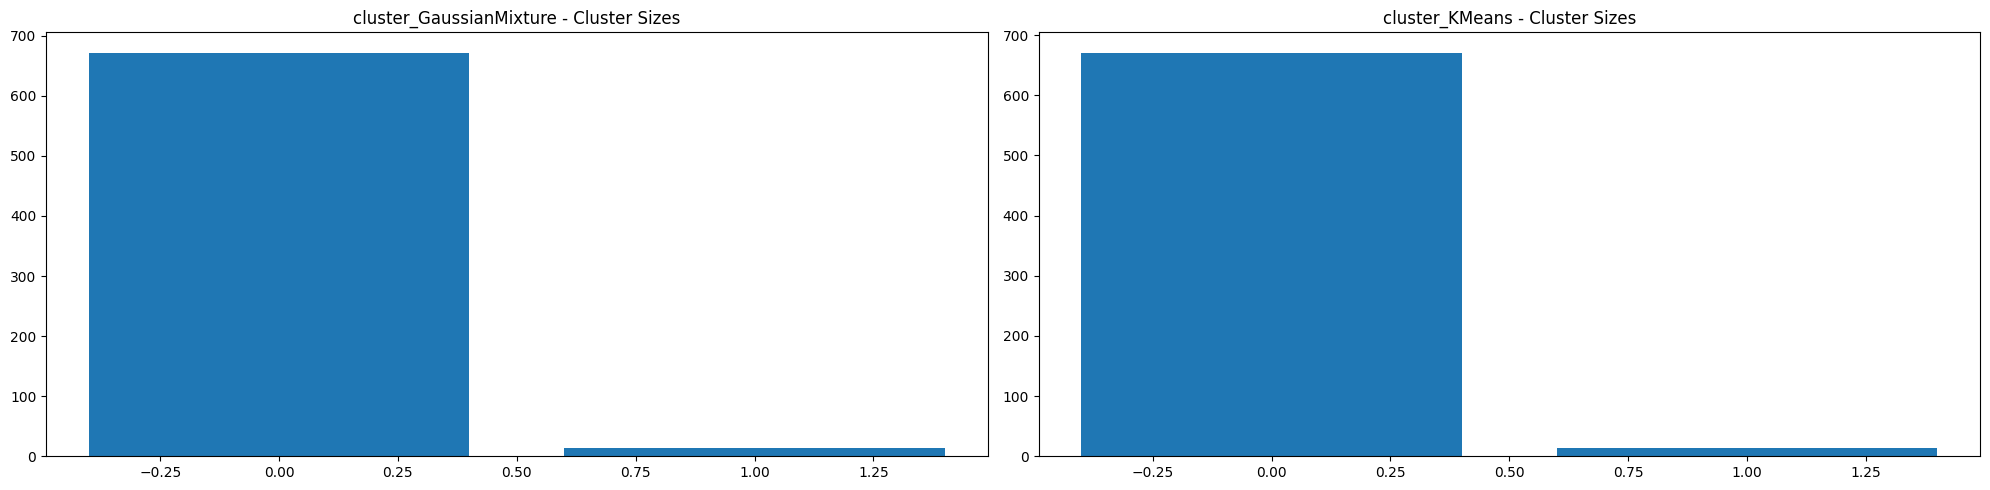

In [86]:
plt_cluster_size(df_hex_pickup_clust)

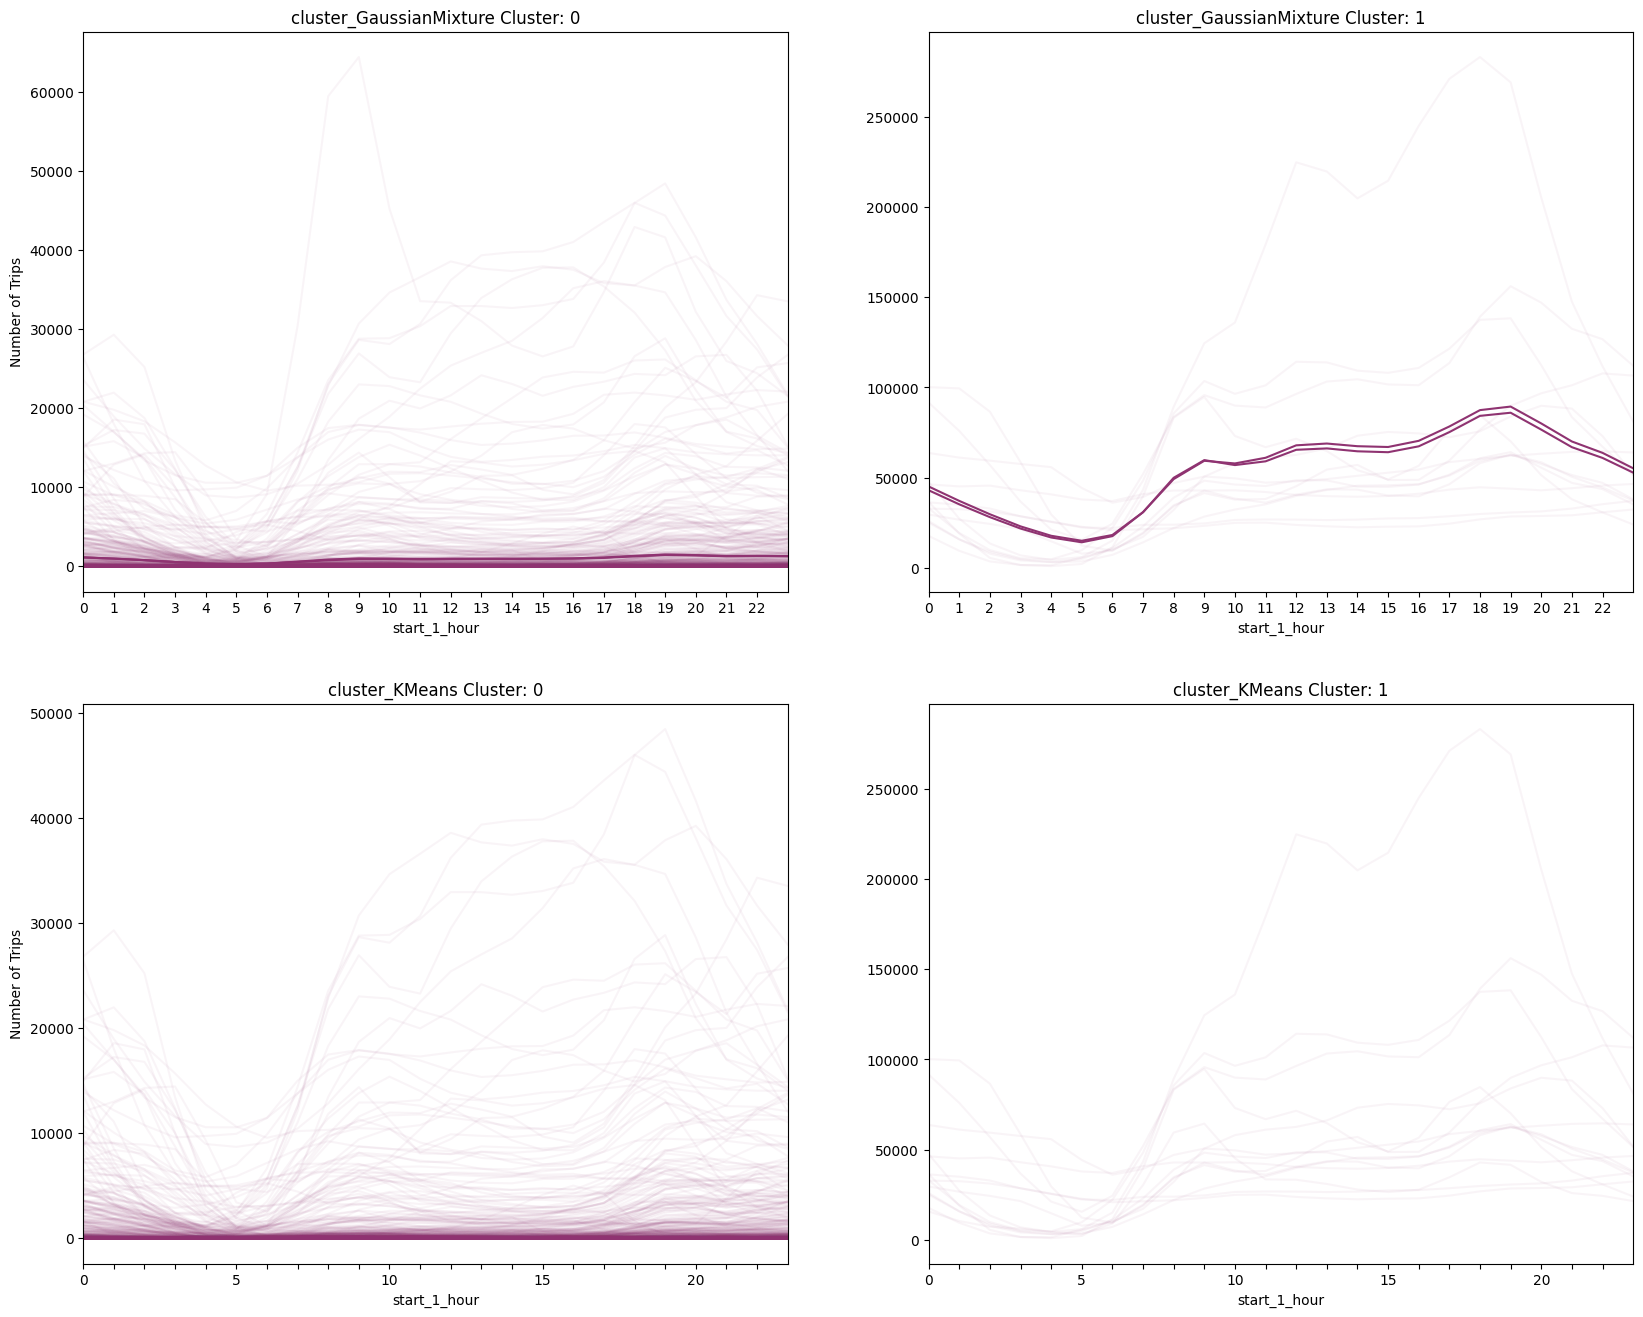

In [87]:
plt_temporal_patterns(df_hex_pickup_clust, num_cluster)

In [88]:
hex_to_map(df_hex_pickup_clust)

## Hexagon demand clustering separated by weekend

Clustering based on same features as the hexagon clustering but additionally separated by is_weekend

In [89]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [90]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [91]:
# separation

df_trips_wd = df_trips[df_trips.is_weekend == 0]
df_trips_we = df_trips[df_trips.is_weekend == 1]

In [92]:
# Aggregate trips based on start_hour and hexagon ID
df_hex_pickup_clust_wd = df_trips_wd.groupby(by=['start_1_hour', f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour']

# unstack to retrieve demand in each hour as feature for each hexagon and fill resulting nan values with demand of zero
df_hex_pickup_clust_wd = df_hex_pickup_clust_wd.unstack(0)
df_hex_pickup_clust_wd = df_hex_pickup_clust_wd.fillna(0)

# rename columns
df_hex_pickup_clust_wd.columns = df_hex_pickup_clust_wd.columns.map(str)

df_hex_pickup_clust_wd

start_1_hour        0     1     2     3     4     5     6      7      8  \
pickup_hex_9                                                              
89266419157ffff   4.0   0.0   1.0   4.0   3.0   3.0   3.0   12.0    5.0   
89266419493ffff   4.0   8.0   3.0   6.0   5.0   2.0   6.0    7.0    9.0   
89266419607ffff   9.0   7.0   4.0  17.0   7.0  10.0  18.0   44.0   47.0   
8926641962fffff   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0    0.0   
8926645204fffff   0.0   0.0   0.0   0.0   0.0   0.0   1.0    0.0    0.0   
...               ...   ...   ...   ...   ...   ...   ...    ...    ...   
89275936b77ffff   1.0   0.0   0.0   1.0   0.0   0.0   4.0    0.0    1.0   
89275936bb3ffff   0.0   0.0   0.0   0.0   0.0   4.0  13.0    1.0    0.0   
89275936bc7ffff   2.0   1.0   4.0   0.0   0.0  10.0  43.0   72.0  128.0   
89275936d37ffff   0.0   0.0   0.0   0.0   1.0   0.0   0.0    3.0    3.0   
89275936d53ffff  22.0  31.0  21.0  24.0  31.0  45.0  64.0  169.0   48.0   

start_1_hour         9  ...    14    15     16    17     18    19    20    21  \
pickup_hex_9            ...                                                     
89266419157ffff    9.0  ...   8.0  10.0    4.0   4.0    7.0   7.0   7.0   2.0   
89266419493ffff    7.0  ...  12.0   7.0    6.0  10.0    7.0   9.0   7.0   4.0   
89266419607ffff   96.0  ...  45.0  81.0  116.0  14.0   19.0  16.0  13.0  15.0   
8926641962fffff    0.0  ...   0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   
8926645204fffff    0.0  ...   0.0   0.0    0.0   0.0    0.0   0.0   0.0   0.0   
...                ...  ...   ...   ...    ...   ...    ...   ...   ...   ...   
89275936b77ffff    0.0  ...   2.0   0.0    0.0   7.0    0.0   0.0   0.0   0.0   
89275936bb3ffff    0.0  ...   3.0   2.0    6.0   7.0    6.0   2.0   1.0   1.0   
89275936bc7ffff  112.0  ...  46.0  96.0  120.0  86.0  106.0  51.0  23.0   8.0   
89275936d37ffff    0.0  ...   0.0   0.0    0.0   0.0    1.0   0.0   0.0   2.0   
89275936d53ffff   40.0  ...  33.0  24.0   29.0  28.0   26.0  18.0  26.0  26.0   

start_1_hour       22    23  
pickup_hex_9                 
89266419157ffff   4.0   2.0  
89266419493ffff   2.0   2.0  
89266419607ffff  18.0   4.0  
8926641962fffff   0.0   0.0  
8926645204fffff   0.0   0.0  
...               ...   ...  
89275936b77ffff   0.0   0.0  
89275936bb3ffff   3.0   3.0  
89275936bc7ffff   2.0   2.0  
89275936d37ffff   1.0   0.0  
89275936d53ffff  26.0  34.0  

[663 rows x 24 columns]

In [93]:
# Aggregate trips based on start_hour and hexagon ID
df_hex_pickup_clust_we = df_trips_we.groupby(by=['start_1_hour', f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour']

# unstack to retrieve demand in each hour as feature for each hexagon and fill resulting nan values with demand of zero
df_hex_pickup_clust_we = df_hex_pickup_clust_we.unstack(0)
df_hex_pickup_clust_we = df_hex_pickup_clust_we.fillna(0)

# rename columns
df_hex_pickup_clust_we.columns = df_hex_pickup_clust_we.columns.map(str)

df_hex_pickup_clust_we

start_1_hour         0      1      2      3      4      5      6      7  \
pickup_hex_9                                                              
89266419157ffff    2.0    1.0    0.0    4.0    1.0    2.0    0.0    0.0   
89266419493ffff    2.0    1.0    3.0    3.0    1.0    7.0    0.0    2.0   
89266419607ffff    2.0    8.0    6.0    6.0    4.0    3.0    5.0    7.0   
8926645206bffff    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
892664520afffff  785.0  615.0  432.0  254.0  184.0  273.0  341.0  516.0   
...                ...    ...    ...    ...    ...    ...    ...    ...   
89275936b77ffff    0.0    0.0    0.0    0.0    0.0    3.0    0.0    0.0   
89275936bb3ffff    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
89275936bc7ffff    4.0    0.0    3.0    0.0    0.0    0.0    0.0    1.0   
89275936d37ffff    3.0    0.0    2.0    1.0    0.0    0.0    0.0    0.0   
89275936d53ffff   47.0   68.0   75.0   52.0   30.0   29.0   21.0   12.0   

start_1_hour         8      9  ...      14      15      16      17      18  \
pickup_hex_9                   ...                                           
89266419157ffff    1.0    2.0  ...     1.0     3.0     3.0     1.0     3.0   
89266419493ffff    3.0    2.0  ...     4.0     1.0     4.0     0.0     5.0   
89266419607ffff    7.0   11.0  ...    13.0     7.0    14.0    15.0     4.0   
8926645206bffff    0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
892664520afffff  763.0  971.0  ...  1527.0  1512.0  1564.0  1568.0  1686.0   
...                ...    ...  ...     ...     ...     ...     ...     ...   
89275936b77ffff    0.0    0.0  ...     4.0     5.0     2.0     1.0     0.0   
89275936bb3ffff    1.0    0.0  ...     4.0     1.0     1.0     1.0     1.0   
89275936bc7ffff    4.0   12.0  ...     0.0     8.0     7.0     8.0    13.0   
89275936d37ffff    0.0    0.0  ...     0.0     4.0     0.0     0.0     1.0   
89275936d53ffff    7.0   14.0  ...    12.0    14.0     9.0    17.0    22.0   

start_1_hour         19      20      21      22      23  
pickup_hex_9                                             
89266419157ffff     2.0     1.0     0.0     0.0     0.0  
89266419493ffff     5.0     2.0     5.0     3.0     2.0  
89266419607ffff    10.0     9.0     3.0     4.0     4.0  
8926645206bffff     0.0     0.0     0.0     0.0     0.0  
892664520afffff  1716.0  2132.0  2242.0  2106.0  1984.0  
...                 ...     ...     ...     ...     ...  
89275936b77ffff     0.0     2.0     3.0     1.0     0.0  
89275936bb3ffff     0.0     0.0     3.0     0.0     0.0  
89275936bc7ffff    10.0     1.0     1.0     5.0     7.0  
89275936d37ffff     0.0     0.0     4.0     0.0     0.0  
89275936d53ffff    36.0    16.0    19.0    32.0    32.0  

[553 rows x 24 columns]

Scale encoded dataframe

In [94]:
df_hex_pickup_clust_wd_scaled = scale_df(df_hex_pickup_clust_wd)
df_hex_pickup_clust_we_scaled = scale_df(df_hex_pickup_clust_we)

Calculate the optimal number of clusters using a Grid Search

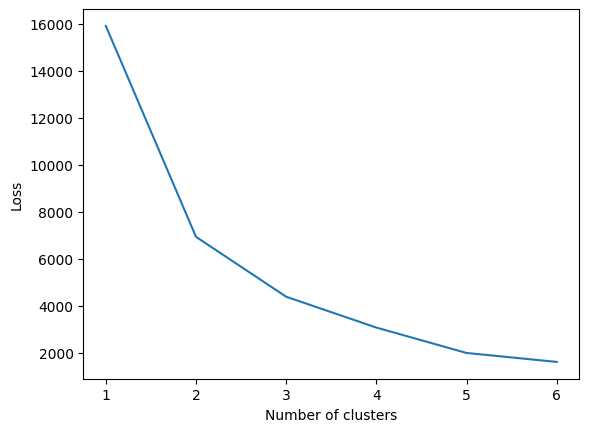

In [95]:
gridSearch(df_hex_pickup_clust_wd_scaled, 6)

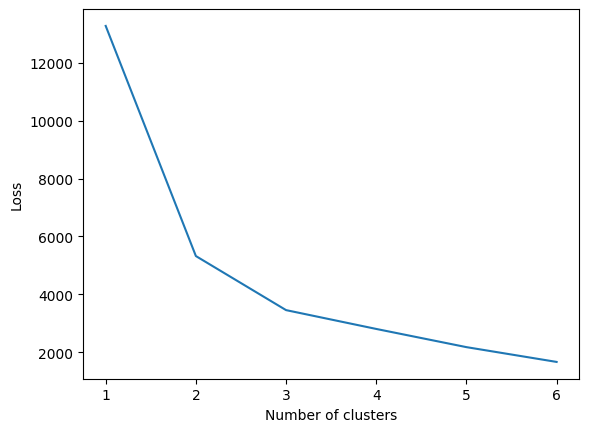

In [96]:
gridSearch(df_hex_pickup_clust_we_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [97]:
num_cluster = 2

#### Gaussian Mixture Model

In [98]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_pickup_clust_wd_scaled, df_hex_pickup_clust_wd)

model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_pickup_clust_we_scaled, df_hex_pickup_clust_we)

In [99]:
df_hex_pickup_clust_we

start_1_hour         0      1      2      3      4      5      6      7  \
pickup_hex_9                                                              
89266419157ffff    2.0    1.0    0.0    4.0    1.0    2.0    0.0    0.0   
89266419493ffff    2.0    1.0    3.0    3.0    1.0    7.0    0.0    2.0   
89266419607ffff    2.0    8.0    6.0    6.0    4.0    3.0    5.0    7.0   
8926645206bffff    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
892664520afffff  785.0  615.0  432.0  254.0  184.0  273.0  341.0  516.0   
...                ...    ...    ...    ...    ...    ...    ...    ...   
89275936b77ffff    0.0    0.0    0.0    0.0    0.0    3.0    0.0    0.0   
89275936bb3ffff    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
89275936bc7ffff    4.0    0.0    3.0    0.0    0.0    0.0    0.0    1.0   
89275936d37ffff    3.0    0.0    2.0    1.0    0.0    0.0    0.0    0.0   
89275936d53ffff   47.0   68.0   75.0   52.0   30.0   29.0   21.0   12.0   

start_1_hour         8      9  ...      15      16      17      18      19  \
pickup_hex_9                   ...                                           
89266419157ffff    1.0    2.0  ...     3.0     3.0     1.0     3.0     2.0   
89266419493ffff    3.0    2.0  ...     1.0     4.0     0.0     5.0     5.0   
89266419607ffff    7.0   11.0  ...     7.0    14.0    15.0     4.0    10.0   
8926645206bffff    0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
892664520afffff  763.0  971.0  ...  1512.0  1564.0  1568.0  1686.0  1716.0   
...                ...    ...  ...     ...     ...     ...     ...     ...   
89275936b77ffff    0.0    0.0  ...     5.0     2.0     1.0     0.0     0.0   
89275936bb3ffff    1.0    0.0  ...     1.0     1.0     1.0     1.0     0.0   
89275936bc7ffff    4.0   12.0  ...     8.0     7.0     8.0    13.0    10.0   
89275936d37ffff    0.0    0.0  ...     4.0     0.0     0.0     1.0     0.0   
89275936d53ffff    7.0   14.0  ...    14.0     9.0    17.0    22.0    36.0   

start_1_hour         20      21      22      23  cluster_GaussianMixture  
pickup_hex_9                                                              
89266419157ffff     1.0     0.0     0.0     0.0                        1  
89266419493ffff     2.0     5.0     3.0     2.0                        1  
89266419607ffff     9.0     3.0     4.0     4.0                        1  
8926645206bffff     0.0     0.0     0.0     0.0                        1  
892664520afffff  2132.0  2242.0  2106.0  1984.0                        1  
...                 ...     ...     ...     ...                      ...  
89275936b77ffff     2.0     3.0     1.0     0.0                        1  
89275936bb3ffff     0.0     3.0     0.0     0.0                        1  
89275936bc7ffff     1.0     1.0     5.0     7.0                        1  
89275936d37ffff     0.0     4.0     0.0     0.0                        1  
89275936d53ffff    16.0    19.0    32.0    32.0                        1  

[553 rows x 25 columns]

#### KMeans

In [100]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_pickup_clust_wd_scaled, df_hex_pickup_clust_wd)

model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_pickup_clust_we_scaled, df_hex_pickup_clust_we)

In [101]:
df_hex_pickup_clust_we

start_1_hour         0      1      2      3      4      5      6      7  \
pickup_hex_9                                                              
89266419157ffff    2.0    1.0    0.0    4.0    1.0    2.0    0.0    0.0   
89266419493ffff    2.0    1.0    3.0    3.0    1.0    7.0    0.0    2.0   
89266419607ffff    2.0    8.0    6.0    6.0    4.0    3.0    5.0    7.0   
8926645206bffff    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
892664520afffff  785.0  615.0  432.0  254.0  184.0  273.0  341.0  516.0   
...                ...    ...    ...    ...    ...    ...    ...    ...   
89275936b77ffff    0.0    0.0    0.0    0.0    0.0    3.0    0.0    0.0   
89275936bb3ffff    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   
89275936bc7ffff    4.0    0.0    3.0    0.0    0.0    0.0    0.0    1.0   
89275936d37ffff    3.0    0.0    2.0    1.0    0.0    0.0    0.0    0.0   
89275936d53ffff   47.0   68.0   75.0   52.0   30.0   29.0   21.0   12.0   

start_1_hour         8      9  ...      16      17      18      19      20  \
pickup_hex_9                   ...                                           
89266419157ffff    1.0    2.0  ...     3.0     1.0     3.0     2.0     1.0   
89266419493ffff    3.0    2.0  ...     4.0     0.0     5.0     5.0     2.0   
89266419607ffff    7.0   11.0  ...    14.0    15.0     4.0    10.0     9.0   
8926645206bffff    0.0    0.0  ...     0.0     0.0     0.0     0.0     0.0   
892664520afffff  763.0  971.0  ...  1564.0  1568.0  1686.0  1716.0  2132.0   
...                ...    ...  ...     ...     ...     ...     ...     ...   
89275936b77ffff    0.0    0.0  ...     2.0     1.0     0.0     0.0     2.0   
89275936bb3ffff    1.0    0.0  ...     1.0     1.0     1.0     0.0     0.0   
89275936bc7ffff    4.0   12.0  ...     7.0     8.0    13.0    10.0     1.0   
89275936d37ffff    0.0    0.0  ...     0.0     0.0     1.0     0.0     0.0   
89275936d53ffff    7.0   14.0  ...     9.0    17.0    22.0    36.0    16.0   

start_1_hour         21      22      23  cluster_GaussianMixture  \
pickup_hex_9                                                       
89266419157ffff     0.0     0.0     0.0                        1   
89266419493ffff     5.0     3.0     2.0                        1   
89266419607ffff     3.0     4.0     4.0                        1   
8926645206bffff     0.0     0.0     0.0                        1   
892664520afffff  2242.0  2106.0  1984.0                        1   
...                 ...     ...     ...                      ...   
89275936b77ffff     3.0     1.0     0.0                        1   
89275936bb3ffff     3.0     0.0     0.0                        1   
89275936bc7ffff     1.0     5.0     7.0                        1   
89275936d37ffff     4.0     0.0     0.0                        1   
89275936d53ffff    19.0    32.0    32.0                        1   

start_1_hour     cluster_KMeans  
pickup_hex_9                     
89266419157ffff               0  
89266419493ffff               0  
89266419607ffff               0  
8926645206bffff               0  
892664520afffff               0  
...                         ...  
89275936b77ffff               0  
89275936bb3ffff               0  
89275936bc7ffff               0  
89275936d37ffff               0  
89275936d53ffff               0  

[553 rows x 26 columns]

#### Evaluation

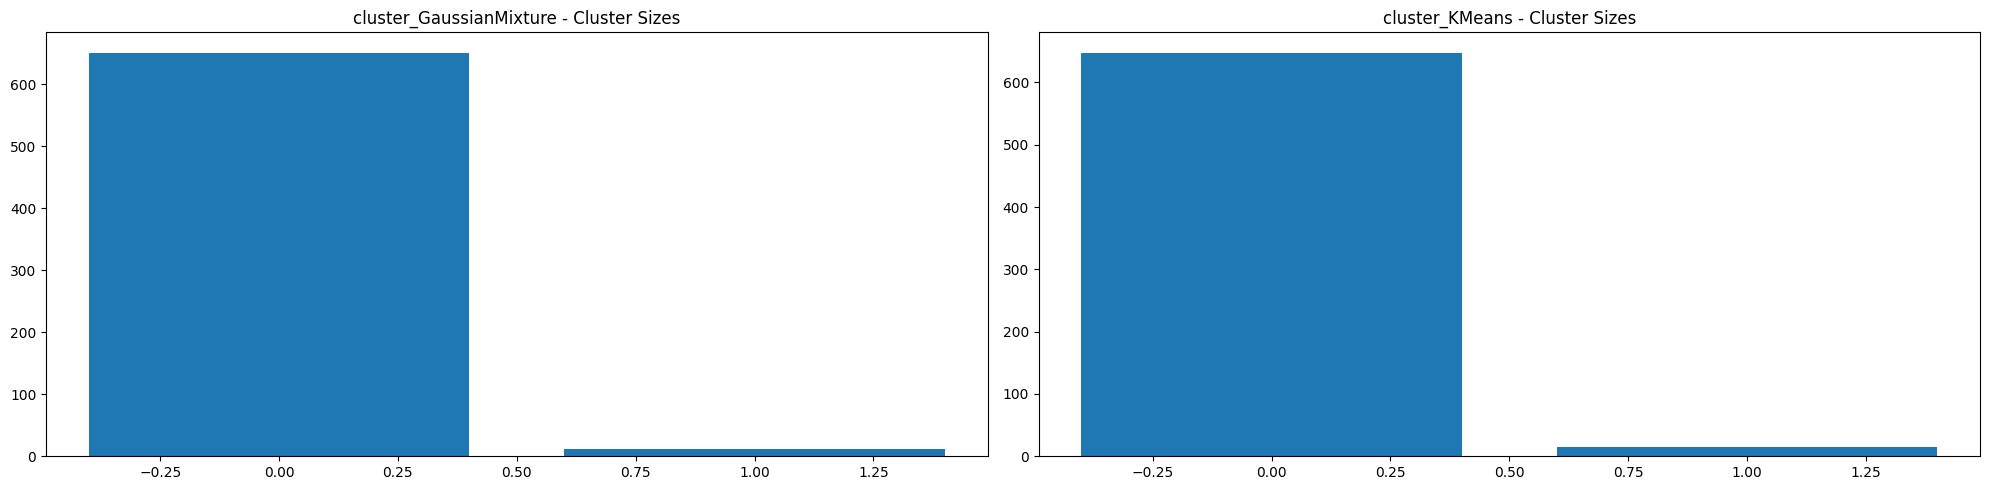

In [102]:
plt_cluster_size(df_hex_pickup_clust_wd)

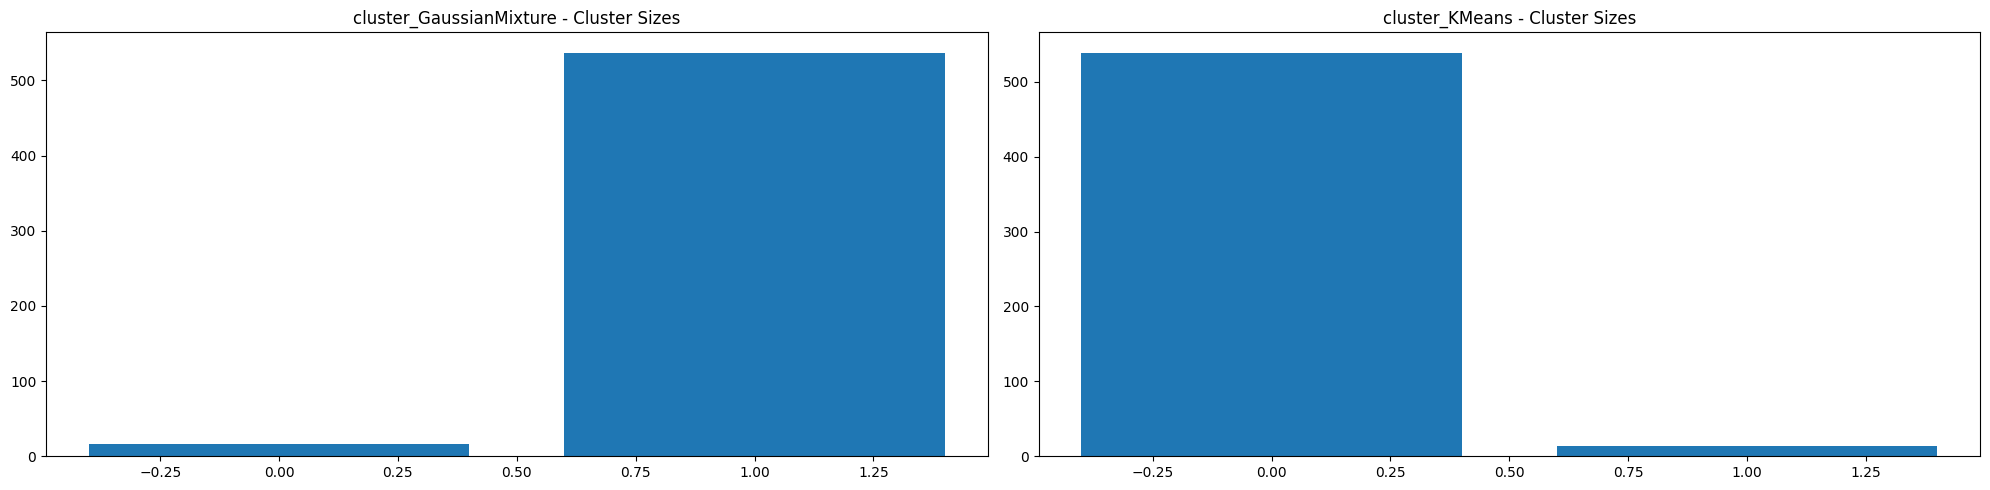

In [103]:
plt_cluster_size(df_hex_pickup_clust_we)

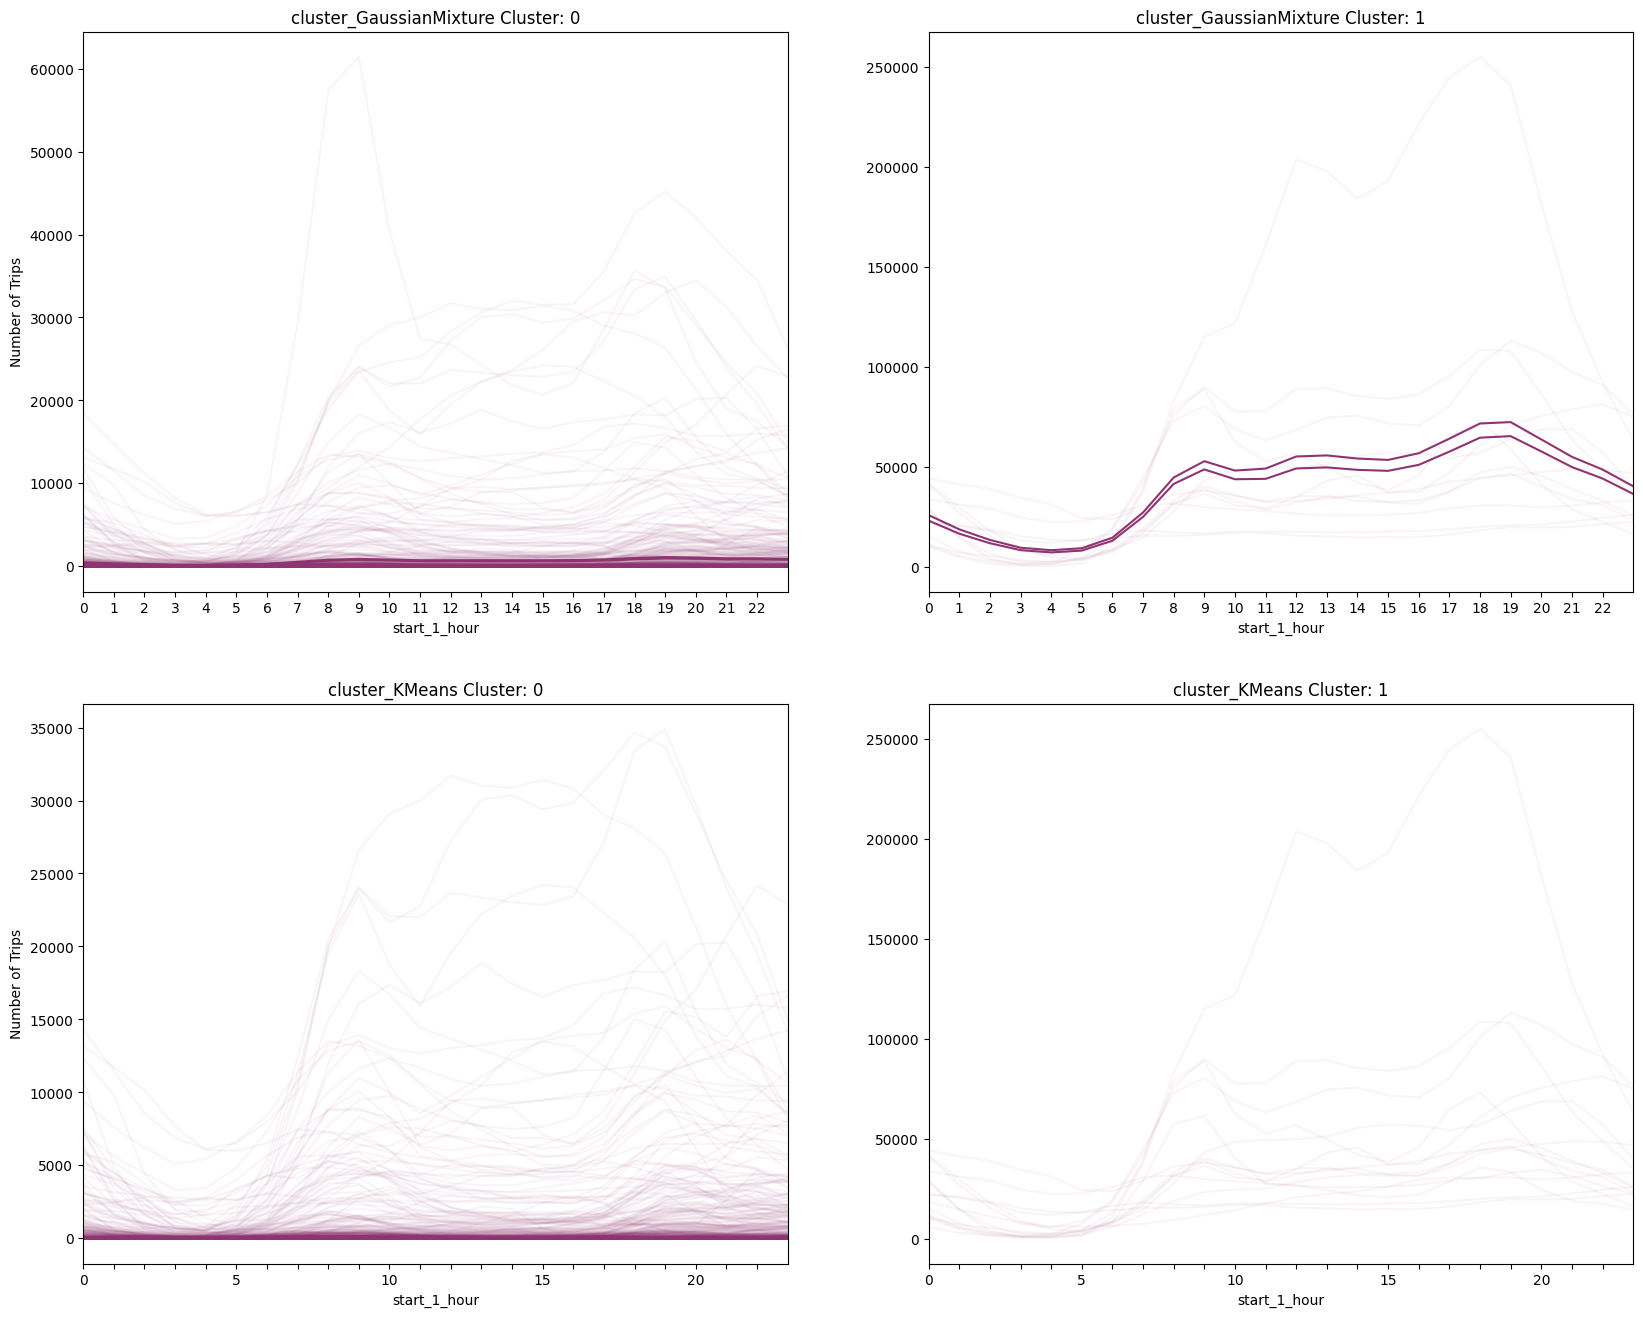

In [104]:
plt_temporal_patterns(df_hex_pickup_clust_wd, num_cluster)

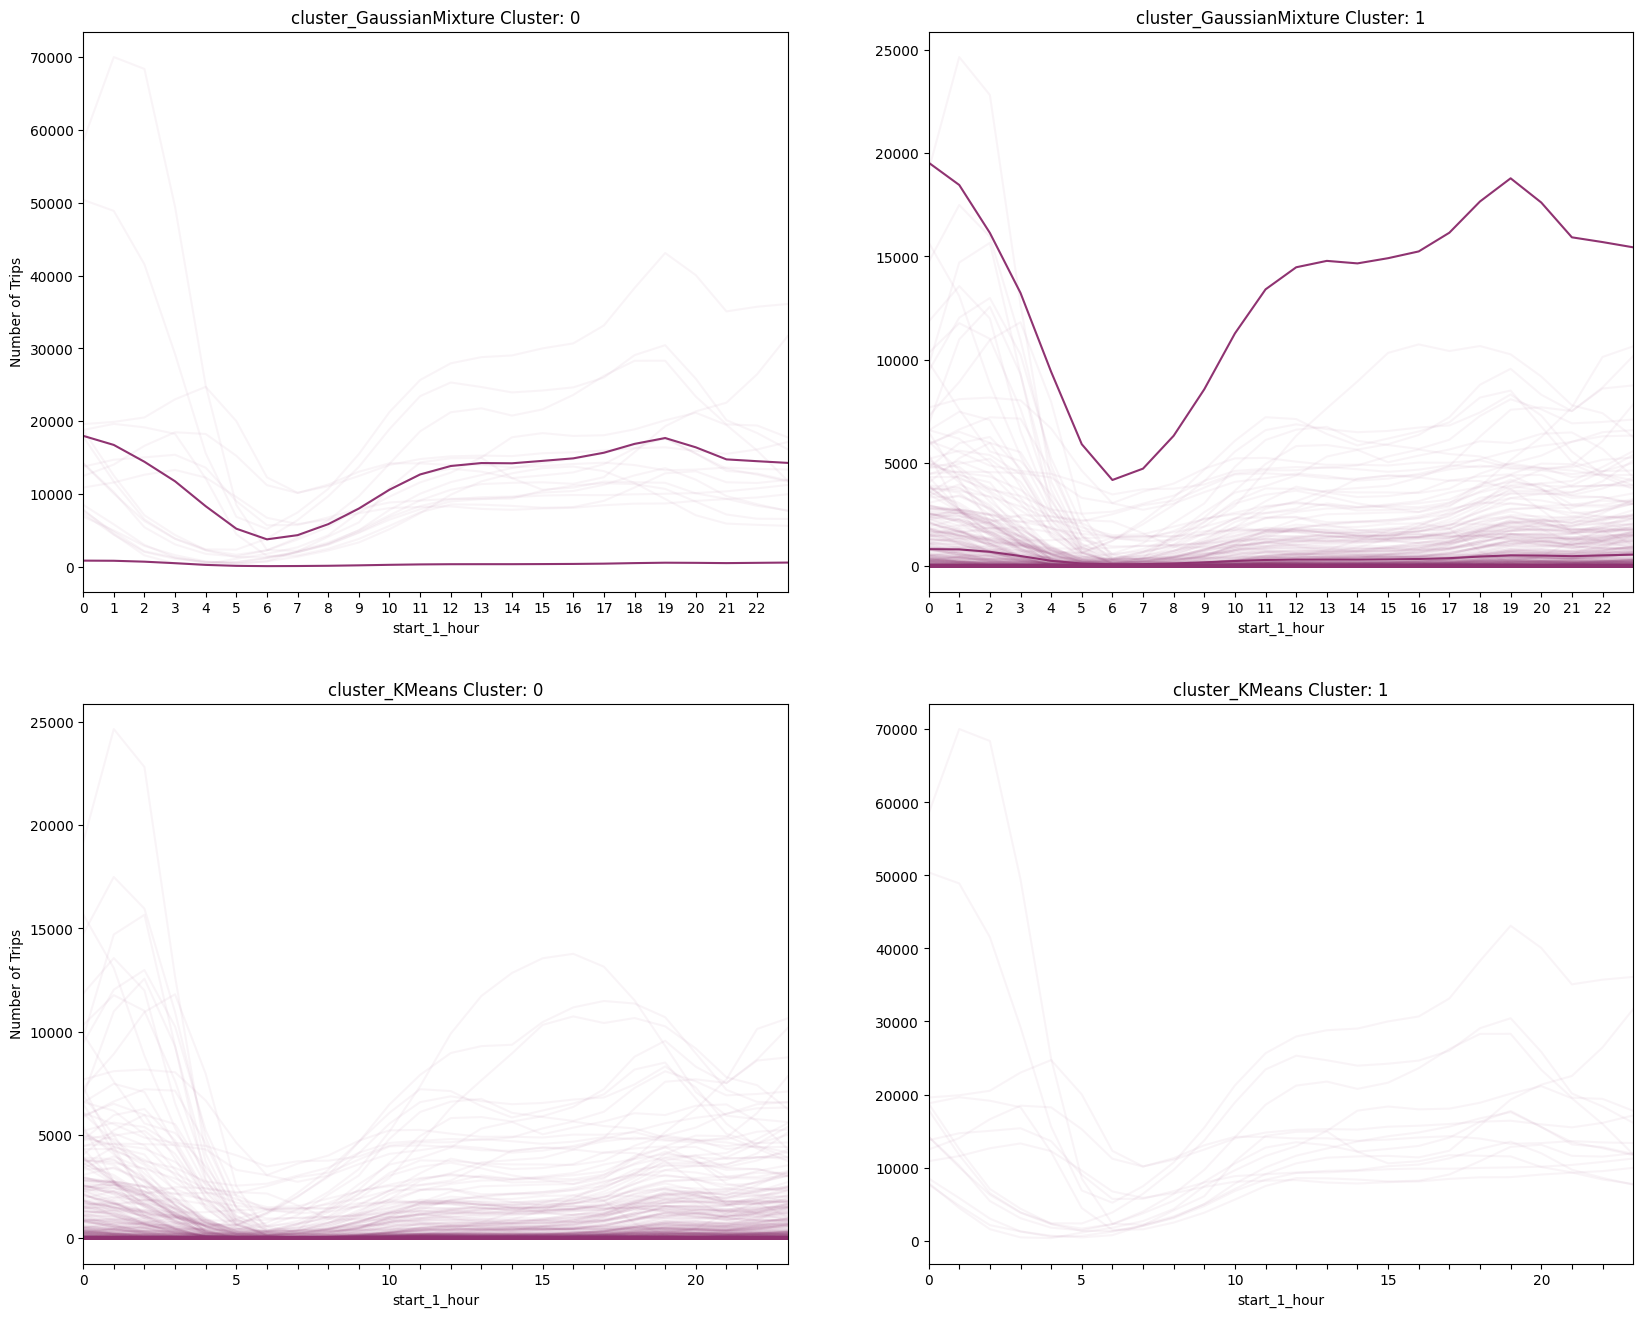

In [105]:
plt_temporal_patterns(df_hex_pickup_clust_we, num_cluster)

In [106]:
df_hex_pickup_clust_unified = df_hex_pickup_clust_wd.join(df_hex_pickup_clust_we, how='outer', lsuffix='_weekday', rsuffix='_weekend')

In [107]:
hex_to_map(df_hex_pickup_clust_unified)

## Hexagon hotspot

Clustering based on same features as trip clustering enhanced by weather feature

In [108]:
df_trips

ts_start_1_hour  start_month  start_weekday  start_weekday_sin  \
0        2014-05-17 10:00:00          5.0              5          -0.974928   
2        2014-05-03 23:00:00          5.0              5          -0.974928   
3        2014-05-17 01:00:00          5.0              5          -0.974928   
5        2014-05-14 09:00:00          5.0              2           0.974928   
6        2014-05-04 03:00:00          5.0              6          -0.781831   
...                      ...          ...            ...                ...   
37395431 2014-04-03 20:00:00          4.0              3           0.433884   
37395432 2014-05-13 23:00:00          5.0              1           0.781831   
37395433 2014-05-14 12:00:00          5.0              2           0.974928   
37395434 2014-05-14 12:00:00          5.0              2           0.974928   
37395435 2014-05-13 23:00:00          5.0              1           0.781831   

          start_weekday_cos  start_1_hour  start_1_hour_sin  start_1_hour_cos  \
0                 -0.222521            10      5.000000e-01         -0.866025   
2                 -0.222521            23     -2.588190e-01          0.965926   
3                 -0.222521             1      2.588190e-01          0.965926   
5                 -0.222521             9      7.071068e-01         -0.707107   
6                  0.623490             3      7.071068e-01          0.707107   
...                     ...           ...               ...               ...   
37395431          -0.900969            20     -8.660254e-01          0.500000   
37395432           0.623490            23     -2.588190e-01          0.965926   
37395433          -0.222521            12      1.224647e-16         -1.000000   
37395434          -0.222521            12      1.224647e-16         -1.000000   
37395435           0.623490            23     -2.588190e-01          0.965926   

          Trip Seconds  Trip Total     pickup_hex_9    dropoff_hex_9  \
0               1080.0       18.95  892664c1acfffff  892664c1617ffff   
2                720.0       11.45  892664c1e4fffff  892664c1e33ffff   
3                480.0       11.85  892664c114fffff  892664c163bffff   
5                180.0        5.05  892664d8ccfffff  892664d88bbffff   
6                840.0        9.85  892664c13afffff  892664c1a07ffff   
...                ...         ...              ...              ...   
37395431         900.0       11.25  892664c1607ffff  892664cac3bffff   
37395432         540.0       15.40  892664c1ecfffff  892664c1607ffff   
37395433         240.0        9.75  892664c1a8bffff  892664cad77ffff   
37395434         360.0        5.05  892664c1ed7ffff  892664c1e8fffff   
37395435         840.0       13.70  892664c1e2fffff  892664c13cfffff   

          Payment Type_Cash  Payment Type_Credit Card  dist_center_pickup  \
0                       1.0                       0.0                   2   
2                       0.0                       1.0                   5   
3                       0.0                       1.0                  12   
5                       1.0                       0.0                  49   
6                       1.0                       0.0                  10   
...                     ...                       ...                 ...   
37395431                1.0                       0.0                  25   
37395432                0.0                       1.0                   7   
37395433                0.0                       1.0                   0   
37395434                1.0                       0.0                   8   
37395435                0.0                       1.0                   3   

          dist_center_dropoff  direction  is_weekend  
0                          26         24           1  
2                           5          0           1  
3                          24         12           1  
5                          40         -9           0  
6                         

In [109]:
df_trips.columns

Index(['ts_start_1_hour', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'start_1_hour', 'start_1_hour_sin',
       'start_1_hour_cos', 'Trip Seconds', 'Trip Total', 'pickup_hex_9',
       'dropoff_hex_9', 'Payment Type_Cash', 'Payment Type_Credit Card',
       'dist_center_pickup', 'dist_center_dropoff', 'direction', 'is_weekend'],
      dtype='object')

Feature selection

In [110]:
# Aggregate trips based hexagon ID
df_hex_demand_clust = pd.DataFrame(df_trips.groupby(by=[f'pickup_hex_{HEX_RES}']).count()['ts_start_1_hour'])
df_hex_demand_clust.rename(columns={'ts_start_1_hour':'demand'}, inplace=True)
df_hex_demand_clust['hex'] =  df_hex_demand_clust.index

# add geometry
df_hex_demand_clust['geometry_lat'] = df_hex_demand_clust['hex'].apply(lambda id: h3.cell_to_latlng(id)[0])
df_hex_demand_clust['geometry_lon'] = df_hex_demand_clust['hex'].apply(lambda id: h3.cell_to_latlng(id)[1])

df_hex_demand_clust.drop(columns='hex', inplace=True)


df_hex_demand_clust

demand  geometry_lat  geometry_lon
pickup_hex_9                                       
89266419157ffff     163     41.662549    -87.539416
89266419493ffff     238     41.706603    -87.536490
89266419607ffff    1020     41.690631    -87.570871
8926641962fffff       1     41.682526    -87.570363
8926645204fffff       1     41.794339    -87.791464
...                 ...           ...           ...
89275936b77ffff      42     41.972514    -87.843377
89275936bb3ffff      81     41.980256    -87.828257
89275936bc7ffff    1394     41.983565    -87.842715
89275936d37ffff      36     41.996368    -87.793771
89275936d53ffff    1533     42.007181    -87.813015

[685 rows x 3 columns]

Scale encoded dataframe

In [111]:
df_hex_demand_clust_scaled = scale_df(df_hex_demand_clust)

Calculate the optimal number of clusters using a Grid Search

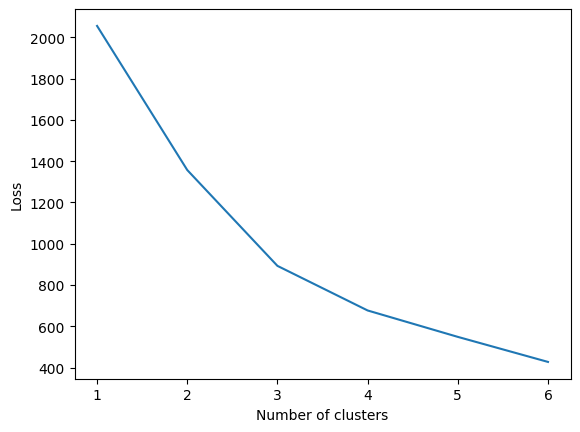

In [112]:
gridSearch(df_hex_demand_clust_scaled, 6)

According to the elbow chart, the optimal number of clusters is 2.

### Fitting the models and prediction

Defining the optimal number of clusters for all models

In [113]:
num_cluster = 3

#### Gaussian Mixture Model

In [114]:
model = GaussianMixture(n_components = num_cluster, random_state=42)
fit_and_predict(model, df_hex_demand_clust_scaled, df_hex_demand_clust)

In [115]:
df_hex_demand_clust

demand  geometry_lat  geometry_lon  cluster_GaussianMixture
pickup_hex_9                                                                
89266419157ffff     163     41.662549    -87.539416                        1
89266419493ffff     238     41.706603    -87.536490                        1
89266419607ffff    1020     41.690631    -87.570871                        1
8926641962fffff       1     41.682526    -87.570363                        1
8926645204fffff       1     41.794339    -87.791464                        1
...                 ...           ...           ...                      ...
89275936b77ffff      42     41.972514    -87.843377                        1
89275936bb3ffff      81     41.980256    -87.828257                        1
89275936bc7ffff    1394     41.983565    -87.842715                        1
89275936d37ffff      36     41.996368    -87.793771                        1
89275936d53ffff    1533     42.007181    -87.813015                        1

[685 rows x 4 columns]

In [116]:
feature_distribution(df_hex_demand_clust, f'cluster_{model.__class__.__name__}')

demand                geometry_lat            \
                                  mean            std         mean       std   
cluster_GaussianMixture                                                        
0                         54895.085859  109573.827290    41.917702  0.055001   
1                           251.032397     506.095675    41.861647  0.089416   
2                        880041.916667  692761.962461    41.894282  0.017630   

                        geometry_lon           cluster_size first_demand  \
                                mean       std                             
cluster_GaussianMixture                                                    
0                         -87.671413  0.043377          198       106762   
1                         -87.689773  0.065461          463            1   
2                         -87.631653  0.014080           24       339916   

                        first_geometry_lat first_geometry_lon  
                                                               
cluster_GaussianMixture                                        
0                                41.792284         -87.768647  
1                                41.662549         -87.539416  
2                                41.913943         -87.630426

#### KMeans

In [117]:
model = KMeans(n_clusters = num_cluster, n_init=10, init="k-means++", random_state=42)
fit_and_predict(model, df_hex_demand_clust_scaled, df_hex_demand_clust)

In [118]:
df_hex_demand_clust

demand  geometry_lat  geometry_lon  cluster_GaussianMixture  \
pickup_hex_9                                                                   
89266419157ffff     163     41.662549    -87.539416                        1   
89266419493ffff     238     41.706603    -87.536490                        1   
89266419607ffff    1020     41.690631    -87.570871                        1   
8926641962fffff       1     41.682526    -87.570363                        1   
8926645204fffff       1     41.794339    -87.791464                        1   
...                 ...           ...           ...                      ...   
89275936b77ffff      42     41.972514    -87.843377                        1   
89275936bb3ffff      81     41.980256    -87.828257                        1   
89275936bc7ffff    1394     41.983565    -87.842715                        1   
89275936d37ffff      36     41.996368    -87.793771                        1   
89275936d53ffff    1533     42.007181    -87.813015                        1   

                 cluster_KMeans  
pickup_hex_9                     
89266419157ffff               2  
89266419493ffff               2  
89266419607ffff               2  
8926641962fffff               2  
8926645204fffff               0  
...                         ...  
89275936b77ffff               0  
89275936bb3ffff               0  
89275936bc7ffff               0  
89275936d37ffff               0  
89275936d53ffff               0  

[685 rows x 5 columns]

In [119]:
feature_distribution(df_hex_demand_clust, f'cluster_{model.__class__.__name__}')

demand                geometry_lat            \
                        mean            std         mean       std   
cluster_KMeans                                                       
0               2.469394e+04   72485.524548    41.928753  0.049430   
1               1.429497e+06  715912.353202    41.903442  0.030976   
2               2.361243e+04   98142.460115    41.789054  0.051613   

               geometry_lon           cluster_size first_demand  \
                       mean       std                             
cluster_KMeans                                                    
0                -87.710208  0.049169          432            1   
1                -87.657566  0.082234           11      1019969   
2                -87.633972  0.043108          242            1   

               first_geometry_lat first_geometry_lon  
                                                      
cluster_KMeans                                        
0                       41.794339         -87.791464  
1                       41.945618         -87.656641  
2                       41.662549         -87.539416

#### Evaluation

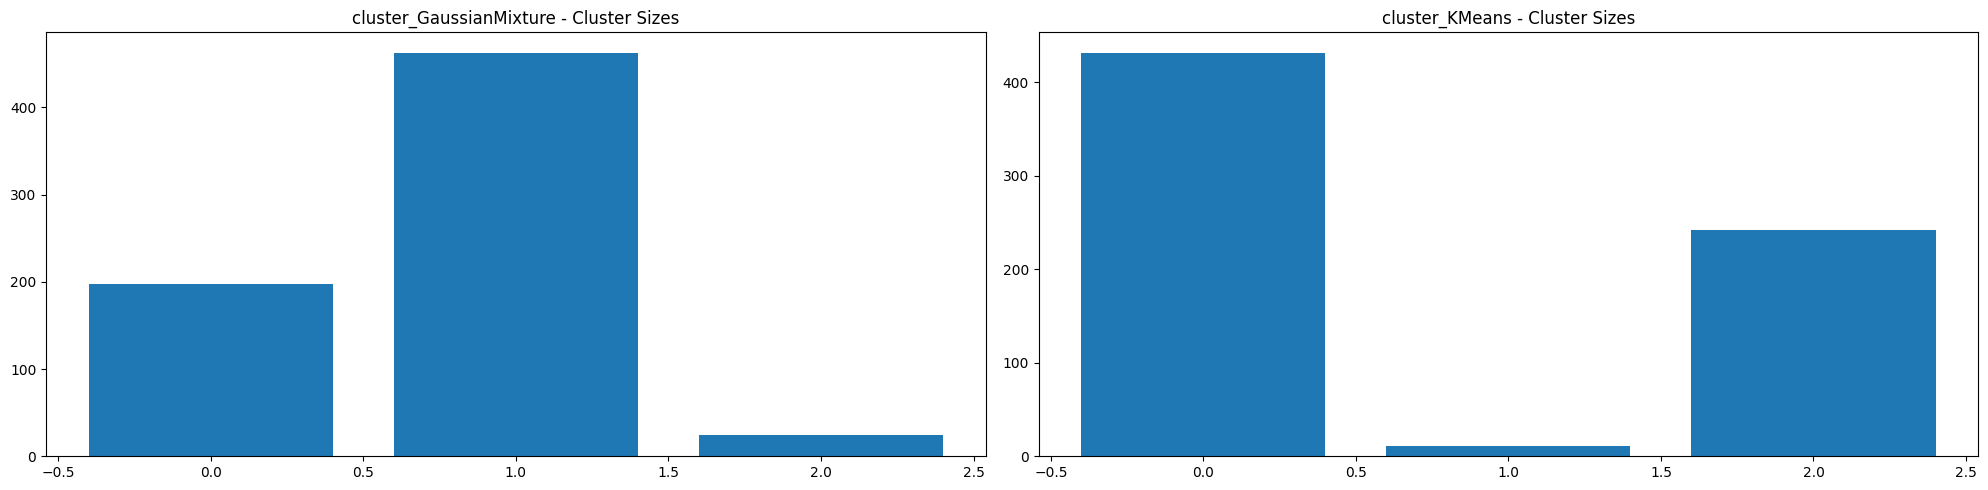

In [120]:
plt_cluster_size(df_hex_demand_clust)

In [121]:
hex_to_map(df_hex_demand_clust)